<!-- # Pronóstico de abandono de los clientes en <img src="dataset/logo_company.png" width="200"> -->
<!-- # Pronóstico de abandono de los clientes en <img src="https://drive.google.com/file/d/1f4qByVPd2zMw3fZAgyHtqqNPYsaeNGdH/view?usp=drive_link" width="120"> -->
# Pronóstico de abandono de los clientes en **Interconnect**
## Proyecto Final <img src="https://d30ql1y9posr4b.cloudfront.net/es-mex/tild3739-6666-4239-b032-623136613631__colordark.svg" width="120">

# Contenido: <a id='cont'></a>

* [Introducción](#int)
* [Librerías](#lib)
* [Extracción de datos](#ext)
* [Pre-procesamiento los datos](#pre)
* [Análisis exploratorio de datos](#eda)
* [Procesamiento de datos](#pro)
* [Entrenar de modelos](#ent)
* [Análisis de resultados](#ana)
* [Conclusión y recomendaciones](#con)

# Introducción <a id='int'></a>

Al operador de telecomunicaciones "Interconnect" le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, 
se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, 
incluyendo información sobre sus planes y contratos.

## Objetivos

Los objetivos a cumplir son los siguientes:

- Realizar un análisis exploratorio de los datos de los clientes, contratos y servicios.
- Crear un modelo de machine learning que permita predecir la probabilidad de cancelación de clientes. 
- Evaluar la calidad del modelo con **AUC-ROC** como principal métrica.

##  Servicios <a id='des'></a>

Interconnect proporciona principalmente dos tipos de servicios:

1. *Comunicación por teléfono fijo.* El teléfono se puede conectar a varias líneas de manera simultánea.
2. *Internet*. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (`SeguridadEnLínea`).
- Una línea de soporte técnico (`SoporteTécnico`).
- Almacenamiento de archivos en la nube y backup de datos (`BackupOnline`).
- Streaming de TV (*StreamingTV*) y directorio de películas (`StreamingPelículas`)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.


# Librerías <a id='lib'></a>

Importamos librerías que necesitaremos en este proyecto

In [7]:
# Generals
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning sklearn
from sklearn.preprocessing   import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier

# Resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler

# Gradient boosting
from lightgbm   import LGBMClassifier
from xgboost    import XGBClassifier
from catboost   import CatBoostClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier


import session_info
import warnings
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

# general variables
line = "===================================================================================================================="

palette = ['#1FE315', '#F56600', '#618DFA', '#A111A8', '#F5A700', '#AEFFE7', '#42C0A7', '#FFA195']

In [9]:
# session_info.show(write_req_file=True,
#                   req_file_name = 'requirements.txt')

# Extracción de datos <a id='ext'></a>

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.


In [856]:
# load data
try:
    data_contract = pd.read_csv('/dataset/contract.csv')
    data_internet = pd.read_csv('/dataset/internet.csv')
    data_personal = pd.read_csv('/dataset/personal.csv')
    data_phone = pd.read_csv('/dataset/phone.csv')
    
except:
    data_contract = pd.read_csv('dataset/contract.csv')
    data_internet = pd.read_csv('dataset/internet.csv')
    data_personal = pd.read_csv('dataset/personal.csv')
    data_phone = pd.read_csv('dataset/phone.csv')

In [857]:
# display data

display(data_contract), display(line)
display(data_internet), display(line)
display(data_personal), display(line)
display(data_phone)

customerID   BeginDate              EndDate            Type  \
0     7590-VHVEG  2020-01-01                   No  Month-to-month   
1     5575-GNVDE  2017-04-01                   No        One year   
2     3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW  2016-05-01                   No        One year   
4     9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...         ...                  ...             ...   
7038  6840-RESVB  2018-02-01                   No        One year   
7039  2234-XADUH  2014-02-01                   No        One year   
7040  4801-JZAZL  2019-03-01                   No  Month-to-month   
7041  8361-LTMKD  2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK  2014-08-01                   No        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0                 Yes           Electronic check           29.85        29.85  
1                  No               Mailed check           56.95       1889.5  
2                 Yes               Mailed check           53.85       108.15  
3                  No  Bank transfer (automatic)           42.30      1840.75  
4                 Yes           Electronic check           70.70       151.65  
...               ...                        ...             ...          ...  
7038              Yes               Mailed check           84.80       1990.5  
7039              Yes    Credit card (automatic)          103.20       7362.9  
7040              Yes           Electronic check           29.60       346.45  
7041              Yes               Mailed check           74.40        306.6  
7042              Yes  Bank transfer (automatic)          105.65       6844.5  

[7043 rows x 8 columns]

'===================================================================================================================='

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingTV StreamingMovies  
0             No          No              No  
1             No          No              No  
2             No          No              No  
3            Yes          No              No  
4             No          No              No  
...          ...         ...             ...  
5512         Yes         Yes             Yes  
5513          No         Yes             Yes  
5514          No          No              No  
5515          No          No              No  
5516         Yes         Yes             Yes  

[5517 rows x 8 columns]

'===================================================================================================================='

customerID  gender  SeniorCitizen Partner Dependents
0     7590-VHVEG  Female              0     Yes         No
1     5575-GNVDE    Male              0      No         No
2     3668-QPYBK    Male              0      No         No
3     7795-CFOCW    Male              0      No         No
4     9237-HQITU  Female              0      No         No
...          ...     ...            ...     ...        ...
7038  6840-RESVB    Male              0     Yes        Yes
7039  2234-XADUH  Female              0     Yes        Yes
7040  4801-JZAZL  Female              0     Yes        Yes
7041  8361-LTMKD    Male              1     Yes         No
7042  3186-AJIEK    Male              0      No         No

[7043 rows x 5 columns]

'===================================================================================================================='

customerID MultipleLines
0     5575-GNVDE            No
1     3668-QPYBK            No
2     9237-HQITU            No
3     9305-CDSKC           Yes
4     1452-KIOVK           Yes
...          ...           ...
6356  2569-WGERO            No
6357  6840-RESVB           Yes
6358  2234-XADUH           Yes
6359  8361-LTMKD           Yes
6360  3186-AJIEK            No

[6361 rows x 2 columns]

Leimos nuestros datos desde nuestros 4 archivos csv, guardándolos como dataframe con el siguiente nombre y estructura de registros y columnas:
- `data_contract` con 7043 registros × 8 columnas,
- `data_internet` con 5517 registros × 8 columnas,
- `data_personal` con 7043 registros × 5 columnas,
- `data_phone` con 6361 registros × 2 columnas.

# Pre-procesamiento de datos <a id='pre'></a>

Vamos a revisar cada dataset y trabajaremos en los siguientes puntos:
- nombres de columnas
- tipo de datos 
- registros duplicados 
- datos ausentes

Primero vamos a imprimir la información de cada dataframe para tener una idea como está su estructura y sus datos:

In [858]:
# dataframe information

data_contract.info(), display(line)
data_internet.info(), display(line)
data_personal.info(), display(line)
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


'===================================================================================================================='

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


'===================================================================================================================='

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


'===================================================================================================================='

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### - Renombrar columnas: 
Usaremos la convension "snake_case" para transformar los nombres de las columnas de cada dataset:

In [859]:
# Funtion "to_snake_case" 
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [860]:
data_contract = data_contract.rename(columns = lambda x: to_snake_case(x))
data_internet = data_internet.rename(columns = lambda x: to_snake_case(x))
data_personal = data_personal.rename(columns = lambda x: to_snake_case(x))
data_phone    =    data_phone.rename(columns = lambda x: to_snake_case(x))

In [861]:
print(f'Columns contract: {list(data_contract.columns)}') 
print(f'Columns internet: {list(data_internet.columns)}') 
print(f'Columns personal: {list(data_personal.columns)}') 
print(f'Columns phone:    {list(data_phone.columns)}')

Columns contract: ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
Columns internet: ['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
Columns personal: ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
Columns phone:    ['customer_id', 'multiple_lines']


### - Corregir tipos de datos:

Vamos a corregir los tipos de datos en cada dataset de la siguiente manera:

- En el `data_contract`- 'begin_date' cambiar a: `datetime`, 'paperless_billing' cambiar a: `int` (1,0), ['type', 'payment_method'] cambiar a: `category` y `total_charges` cambiar a: `float` (existen espacios en blanco, por lo que cambiará a `NaN` antes de la conversión a float, para que no exista error).

- En el `data_internet` - 'internet_service' cambiar a: `category`, ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies'] cambiar a: `int` (1,0)

- En el `data_personal`- 'gender'  cambiar a:  `category`, ['partner', 'dependents']  cambiar a: `int` (1,0).

- En el `data_phone` - 'multiple_lines'  cambiar a: `category`

In [862]:
# Change data type

data_contract.begin_date = pd.to_datetime(data_contract.begin_date, format="%Y-%m-%d")
data_contract['paperless_billing'] = data_contract['paperless_billing'].apply({'Yes': 1, 'No': 0}.get)
data_contract[['type','payment_method']] = data_contract[['type', 'payment_method']].astype('category')
data_contract.total_charges = data_contract.total_charges.replace(' ', np.nan).astype('float')

data_internet.internet_service = data_internet.internet_service.astype('category')
data_internet[['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']] = data_internet[[
               'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']].applymap({'Yes': 1, 'No': 0}.get)

data_personal.gender = data_personal.gender.astype('category')
data_personal[['partner', 'dependents']] = data_personal[['partner', 'dependents']].applymap({'Yes': 1, 'No': 0}.get)

data_phone.multiple_lines = data_phone.multiple_lines.astype('category')

In [863]:
display(data_contract), display(line)
display(data_internet), display(line)
display(data_personal), display(line)
display(data_phone)

customer_id begin_date             end_date            type  \
0     7590-VHVEG 2020-01-01                   No  Month-to-month   
1     5575-GNVDE 2017-04-01                   No        One year   
2     3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3     7795-CFOCW 2016-05-01                   No        One year   
4     9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   
...          ...        ...                  ...             ...   
7038  6840-RESVB 2018-02-01                   No        One year   
7039  2234-XADUH 2014-02-01                   No        One year   
7040  4801-JZAZL 2019-03-01                   No  Month-to-month   
7041  8361-LTMKD 2019-07-01  2019-11-01 00:00:00  Month-to-month   
7042  3186-AJIEK 2014-08-01                   No        Two year   

      paperless_billing             payment_method  monthly_charges  \
0                     1           Electronic check            29.85   
1                     0               Mailed check            56.95   
2                     1               Mailed check            53.85   
3                     0  Bank transfer (automatic)            42.30   
4                     1           Electronic check            70.70   
...                 ...                        ...              ...   
7038                  1               Mailed check            84.80   
7039                  1    Credit card (automatic)           103.20   
7040                  1           Electronic check            29.60   
7041                  1               Mailed check            74.40   
7042                  1  Bank transfer (automatic)           105.65   

      total_charges  
0             29.85  
1           1889.50  
2            108.15  
3           1840.75  
4            151.65  
...             ...  
7038        1990.50  
7039        7362.90  
7040         346.45  
7041         306.60  
7042        6844.50  

[7043 rows x 8 columns]

'===================================================================================================================='

customer_id internet_service  online_security  online_backup  \
0     7590-VHVEG              DSL                0              1   
1     5575-GNVDE              DSL                1              0   
2     3668-QPYBK              DSL                1              1   
3     7795-CFOCW              DSL                1              0   
4     9237-HQITU      Fiber optic                0              0   
...          ...              ...              ...            ...   
5512  6840-RESVB              DSL                1              0   
5513  2234-XADUH      Fiber optic                0              1   
5514  4801-JZAZL              DSL                1              0   
5515  8361-LTMKD      Fiber optic                0              0   
5516  3186-AJIEK      Fiber optic                1              0   

      device_protection  tech_support  streaming_tv  streaming_movies  
0                     0             0             0                 0  
1                     1             0             0                 0  
2                     0             0             0                 0  
3                     1             1             0                 0  
4                     0             0             0                 0  
...                 ...           ...           ...               ...  
5512                  1             1             1                 1  
5513                  1             0             1                 1  
5514                  0             0             0                 0  
5515                  0             0             0                 0  
5516                  1             1             1                 1  

[5517 rows x 8 columns]

'===================================================================================================================='

customer_id  gender  senior_citizen  partner  dependents
0     7590-VHVEG  Female               0        1           0
1     5575-GNVDE    Male               0        0           0
2     3668-QPYBK    Male               0        0           0
3     7795-CFOCW    Male               0        0           0
4     9237-HQITU  Female               0        0           0
...          ...     ...             ...      ...         ...
7038  6840-RESVB    Male               0        1           1
7039  2234-XADUH  Female               0        1           1
7040  4801-JZAZL  Female               0        1           1
7041  8361-LTMKD    Male               1        1           0
7042  3186-AJIEK    Male               0        0           0

[7043 rows x 5 columns]

'===================================================================================================================='

customer_id multiple_lines
0     5575-GNVDE             No
1     3668-QPYBK             No
2     9237-HQITU             No
3     9305-CDSKC            Yes
4     1452-KIOVK            Yes
...          ...            ...
6356  2569-WGERO             No
6357  6840-RESVB            Yes
6358  2234-XADUH            Yes
6359  8361-LTMKD            Yes
6360  3186-AJIEK             No

[6361 rows x 2 columns]

In [864]:
# dataframe information

data_contract.info(), display(line)
data_internet.info(), display(line)
data_personal.info(), display(line)
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 344.3+ KB


'===================================================================================================================='

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        5517 non-null   object  
 1   internet_service   5517 non-null   category
 2   online_security    5517 non-null   int64   
 3   online_backup      5517 non-null   int64   
 4   device_protection  5517 non-null   int64   
 5   tech_support       5517 non-null   int64   
 6   streaming_tv       5517 non-null   int64   
 7   streaming_movies   5517 non-null   int64   
dtypes: category(1), int64(6), object(1)
memory usage: 307.3+ KB


'===================================================================================================================='

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     7043 non-null   object  
 1   gender          7043 non-null   category
 2   senior_citizen  7043 non-null   int64   
 3   partner         7043 non-null   int64   
 4   dependents      7043 non-null   int64   
dtypes: category(1), int64(3), object(1)
memory usage: 227.2+ KB


'===================================================================================================================='

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     6361 non-null   object  
 1   multiple_lines  6361 non-null   category
dtypes: category(1), object(1)
memory usage: 56.2+ KB


### - Registros duplicados

In [865]:
# Check rows and values duplicated

print(data_contract.duplicated().sum())
print(data_internet.duplicated().sum())
print(data_personal.duplicated().sum())
print(data_phone.duplicated().sum())

# --------------------------------------------------------

print(data_contract.customer_id.duplicated().sum())
print(data_internet.customer_id.duplicated().sum())
print(data_personal.customer_id.duplicated().sum())
print(data_phone.customer_id.duplicated().sum())

0
0
0
0
0
0
0
0


No existen registros duplicados en ningún dataset. Tampoco, los clientes (customer_id) no se encuentran duplicados en ninguna tabla, existe un registro único en cada una de las tablas.

### - Valores ausentes

Revisemos la presencia de valores ausentes en todos los dataset.

In [866]:
# Check NaN values
print(data_contract.isna().sum()), print(line)
print(data_internet.isna().sum()), print(line)
print(data_personal.isna().sum()), print(line)
print(data_phone.isna().sum())

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
dtype: int64
customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64
customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64
customer_id       0
multiple_lines    0
dtype: int64


In [867]:
# Check rows with NaN
nan = data_contract.query('total_charges.isna()')
nan

customer_id begin_date end_date      type  paperless_billing  \
488   4472-LVYGI 2020-02-01       No  Two year                  1   
753   3115-CZMZD 2020-02-01       No  Two year                  0   
936   5709-LVOEQ 2020-02-01       No  Two year                  0   
1082  4367-NUYAO 2020-02-01       No  Two year                  0   
1340  1371-DWPAZ 2020-02-01       No  Two year                  0   
3331  7644-OMVMY 2020-02-01       No  Two year                  0   
3826  3213-VVOLG 2020-02-01       No  Two year                  0   
4380  2520-SGTTA 2020-02-01       No  Two year                  0   
5218  2923-ARZLG 2020-02-01       No  One year                  1   
6670  4075-WKNIU 2020-02-01       No  Two year                  0   
6754  2775-SEFEE 2020-02-01       No  Two year                  1   

                 payment_method  monthly_charges  total_charges  
488   Bank transfer (automatic)            52.55            NaN  
753                Mailed check            20.25            NaN  
936                Mailed check            80.85            NaN  
1082               Mailed check            25.75            NaN  
1340    Credit card (automatic)            56.05            NaN  
3331               Mailed check            19.85            NaN  
3826               Mailed check            25.35            NaN  
4380               Mailed check            20.00            NaN  
5218               Mailed check            19.70            NaN  
6670               Mailed check            73.35            NaN  
6754  Bank transfer (automatic)            61.90            NaN

In [868]:
# Check "begin_date"	

print(f'Oldest date {data_contract.begin_date.min()}')
print(f'Newest date {data_contract.begin_date.max()}')

Oldest date 2013-10-01 00:00:00
Newest date 2020-02-01 00:00:00


Basándonos en la información de los registros que no tienen un valor asignado en el total de cargos "total_charges", vemos que hay 11 clientes que tienen una fecha de inicio (begin_date) igual a 2020-02-01. Esto podría indicar que estos clientes son nuevos, ya que la fecha indicada es la más reciente, y aún no han acumulado cargos totales. Dicho esto, vamos a asignar el valor del cargo mensual "monthly_charges" en el total de cargos "total_charges".

In [869]:
# Fill values NaN with monthly_charges
data_contract['total_charges'] = data_contract['total_charges'].fillna(data_contract['monthly_charges'])

In [870]:
# Check again without NaN
print(f'NaN {data_contract.total_charges.isna().sum()}')

# Check changes, the values filled in "total_charges"
data_contract.iloc[nan.index]

NaN 0


customer_id begin_date end_date      type  paperless_billing  \
488   4472-LVYGI 2020-02-01       No  Two year                  1   
753   3115-CZMZD 2020-02-01       No  Two year                  0   
936   5709-LVOEQ 2020-02-01       No  Two year                  0   
1082  4367-NUYAO 2020-02-01       No  Two year                  0   
1340  1371-DWPAZ 2020-02-01       No  Two year                  0   
3331  7644-OMVMY 2020-02-01       No  Two year                  0   
3826  3213-VVOLG 2020-02-01       No  Two year                  0   
4380  2520-SGTTA 2020-02-01       No  Two year                  0   
5218  2923-ARZLG 2020-02-01       No  One year                  1   
6670  4075-WKNIU 2020-02-01       No  Two year                  0   
6754  2775-SEFEE 2020-02-01       No  Two year                  1   

                 payment_method  monthly_charges  total_charges  
488   Bank transfer (automatic)            52.55          52.55  
753                Mailed check            20.25          20.25  
936                Mailed check            80.85          80.85  
1082               Mailed check            25.75          25.75  
1340    Credit card (automatic)            56.05          56.05  
3331               Mailed check            19.85          19.85  
3826               Mailed check            25.35          25.35  
4380               Mailed check            20.00          20.00  
5218               Mailed check            19.70          19.70  
6670               Mailed check            73.35          73.35  
6754  Bank transfer (automatic)            61.90          61.90

# Análisis exploratorio de datos <a id='eda'></a>

*Vamos analizar nuestros datos respondiendo las siguientes preguntas:*

- ¿Cuál es la distribución de los cargos mensuales y los cargos totales entre los clientes?
- ¿Hay diferencias en los cargos mensuales o totales entre diferentes grupos de clientes, como por ejemplo entre hombres y mujeres, ciudadanos jubilados y no jubilados, o entre aquellos con o sin dependientes?
- ¿Qué métodos de pago son los más populares entre los clientes?
- ¿Hay una relación entre el tipo de contrato y otros factores como los cargos mensuales o totales, el método de pago o el uso de facturación electrónica?
- ¿Qué servicios de internet son los más populares entre los clientes?
- ¿Hay alguna relación entre el uso de servicios de internet y otros factores como el género, la edad o el tipo de contrato?


*Teniendo claro nuestro objetivo el cual será crea un modelo para saber qué clientes finalizarán contrato con la empresa, hay varias preguntas adicionales que podemos responder para prepararnos para el modelado. Vamos a descrubir:*

* ¿Qué porcentaje de clientes cancelaron el contrato con la empresa?.
* ¿Hay diferencias en la tasa de cancelación o finalización del contrato entre diferentes grupos de clientes, como por ejemplo entre hombres y mujeres, ciudadanos mayores y no mayores, o entre aquellos con o sin dependientes?
* ¿Hay una relación entre la duración del contrato y la probabilidad de cancelación del contrato?
* ¿Qué factores están más fuertemente asociados con la cancelación o finalización del contrato? Por ejemplo, ¿los clientes que usan facturación electrónica 
 tienen más o menos probabilidades de finalizar el contrato que aquellos que no lo hacen?
* ¿Hay alguna relación entre el uso de servicios de internet y la probabilidad de cancelación o finalización del contrato?

## Preparar los datos

Antes de empezar con el EDA, necesitamos a crear un nuevo dataframe y crearemos nuevas columnas.

- Crear dataframe "customers": Crear una tabla llamada "customers" donde condensaremos toda la información de los 3 datasets de los clientes. 

In [871]:
# Create "customers" merge 4 dataframes

customers = pd.merge(data_contract, data_personal, on='customer_id', how='outer')
customers = pd.merge(    customers, data_internet, on='customer_id', how='outer')
customers = pd.merge(    customers,    data_phone, on='customer_id', how='outer')

In [872]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   category      
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   int64         
 11  dependents         7043 non-null   int64         
 12  internet_service   5517 non-null   category      
 13  online_security    5517 non-null   float64       
 14  online_b

- Se crearon nuevos NaN ya que todos los clientes no tienen contratados todos los servicios de internet y linea telefónica fija. Por lo que se deberá realizar una imputación a estos valores ausentes. Las acciones a realizar son las siguientes:
    - Para todos los servicios que no tengan información es porque el cliente no tiene habilitado el servicio, por ende, imputaremos el valor 0 (como un No).
    - Para la columna 'internet_service' que no tenga información es por que el cliente no tiene contratado internet ni por DSL ni por fibra óptica, por lo que se se agregará una nueva categoría llamada 'Neither' indicando que no posee ninguno.
    - Para la columna 'multiple_lines' asignaremos la categoría 'No line' para los valores ausentes, ya que si no tiene información es por que el cliente no tiene asignada una línea de telefono.

In [873]:
# Fill NaN with False
services = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
customers[services] = customers[services].fillna(0).astype(int)

# Fill NaN with "Neither"
customers['internet_service'] = customers['internet_service'].cat.add_categories(['Neither']).fillna('Neither')

# Fill NaN With "No line"
customers['multiple_lines'] = customers['multiple_lines'].cat.add_categories(['No line']).fillna('No line')

Agregaremos las columnas:
- `phone_line` con valores 1 o 0 (representando Si, No). Si la columna 'multiple_lines' tiene asignado 'No line' es decir no tiene linea asignada tomará el valor 0. Por lo contrario, tomará 1.

- `internet` con valores  1 o 0 (representando Si, No). Si el valor de la columna 'internet_service' es igual a 'Neither, entonces se asignará el valor 0, caso contrario se asignará 1.

- `tenure_month` tendrá el valor del número de meses de permanencia que tiene el cliente, calculado desde la fecha de inicio de su contrato con la columna 'begin_date' hasta la fecha máxima de los datos.

- `churn_customer` se le asignará un `1` si el cliente abandonó la empresa, calculada en base a la columna 'end_date', la cual contiene fechas de finalización para los clientes que ya se fueron, y un `0` para los clientes que no se fueron.

In [874]:
# Add column: 'line' bool values: True, False.
customers['phone_line'] = customers['multiple_lines'].apply(lambda x: 0 if x == 'No line' else 1)

# Add column: 'internet' bool values: True,False.
customers['internet'] = customers['internet_service'].apply(lambda x: 0 if x == 'Neither' else 1)

# Add column: 'tenure_month' from begin_date and end_date / latest
customers['tenure_month'] = customers.apply(lambda x: ((customers['begin_date'].max() - x['begin_date']).days / 30.44) if x['end_date'] == "No" 
                                            else ((pd.to_datetime(x['end_date']) - x['begin_date']).days / 30.44), axis=1).astype(int)

# Create column 'churn_customer'
customers['churn_customer'] = customers['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [875]:
customers.head(5)

customer_id begin_date             end_date            type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

   paperless_billing             payment_method  monthly_charges  \
0                  1           Electronic check            29.85   
1                  0               Mailed check            56.95   
2                  1               Mailed check            53.85   
3                  0  Bank transfer (automatic)            42.30   
4                  1           Electronic check            70.70   

   total_charges  gender  senior_citizen  ...  online_backup  \
0          29.85  Female               0  ...              1   
1        1889.50    Male               0  ...              0   
2         108.15    Male               0  ...              1   
3        1840.75    Male               0  ...              0   
4         151.65  Female               0  ...              0   

   device_protection tech_support  streaming_tv  streaming_movies  \
0                  0            0             0                 0   
1                  1            0             0                 0   
2                  0            0             0                 0   
3                  1            1             0                 0   
4                  0            0             0                 0   

   multiple_lines  phone_line  internet  tenure_month churn_customer  
0         No line           0         1             1              0  
1              No           1         1            34              0  
2              No           1         1             2              1  
3         No line           0         1            45              0  
4              No           1         1             2              1  

[5 rows x 24 columns]

In [876]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   category      
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   int64         
 11  dependents         7043 non-null   int64         
 12  internet_service   7043 non-null   category      
 13  online_security    7043 non-null   int32         
 14  online_b

In [877]:
customers.isna().sum().sum()

0

## Función para visualización de gráficos

- Además una función para visualizar los datos de mejor manera:   
    - `plots`: nos ayudará a optimizar el código en la visualización de los datos por medio de diferentes tipos de gráficos, y establecer un formato uniforme. Esta función podrá usarse para dibujar 1 o varios plot en la misma linea o grid, de diferentes tipos pero con un mismo formato de color y presentación.

In [878]:
# Function "plots" to format graphs within a grid line 

def plots(data, columns, kind=None, titles=None, figsize=None):

    '''
    Input parameters:
    "data": dataset
    "columns": columns to use from the dataset
    "kind": type of graphics to use
    "titles": titles to use

    Return:
     Show the graphs in the same line
    '''
    
    # INITIAL SETUP *****************************************************************************************************
    
    # Convert each item in the list to a list
    columns = [x if isinstance(x, list) else [x] for x in columns]

    # Convert in the list to data if it's not
    data_list = data if isinstance(data, list) else [data] # ADD LINE-------
    
    # Graph style 
    sns.set_theme(style="whitegrid")

    # Palette 
    palette = ['#1FE315', '#F56600', '#618DFA', '#A111A8', '#F5A700', '#AEFFE7', '#42C0A7', '#FFA195']
   
    # Number of graphs 
    n_plots = len(columns)

    # Figure size 
    if not figsize:
        figsize = (n_plots * 6, 5)

    # Figure with set of subplots
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)


    # BUCLE ***************************************************************************************************************
    
    # Create the graphs on each axis
    for i, col in enumerate(columns):
        
        data = data_list[i]

        # Count of values in col
        n_col = len(col)

        # Define ax
        if n_plots > 1: # mayor a 1
            ax = axes[i]
        elif n_plots == 1:
            ax = axes

        # SELECT COLOR(S) -------------------------------------------------------------------------------------------------

        if n_col > 1 or kind[i] == 'count' or kind[i] == 'bar':
            #  Count of unique values in categorical column
            n_cat = data[col[-1]].nunique()

            # Create a new color list with only the number of values needed
            colors = palette[i:i+n_cat]
        
        elif n_col == 1:
            color = palette[i]
        
        
        # GRAPH TYPE ------------------------------------------------------------------------------------------------------ 

        if kind:

            #  H I S T O G R A M -------------------------------------------------------------------------------------------
            # x=numerical variable, hue=categorical variable (optional)
            
            if kind[i] == 'hist':
                if n_col == 2:
                    sns.histplot(data, x=col[0], hue=col[1], kde=True, ax=ax, palette=colors, edgecolor="black", alpha=0.5)
                else:
                    sns.histplot(data, x=col[0], kde=True, ax=ax, color=color, edgecolor="black")


            # C O U N T  (BAR GRAPHIC) --------------------------------------------------------------------------
            # x=categorical variable, hue=categorical variable (optional)
            
            elif kind[i] == 'count':
                if n_col == 2:
                    sns.countplot(data=data, x=col[0], ax=ax, palette=colors, hue=col[1])
                else:
                    sns.countplot(data=data, x=col[0], ax=ax, palette=colors)

                # XLabels rotation
                ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
                                               
                # Add labels of percent to bars
                for p in ax.patches:
                    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 3, f'{(p.get_height()/len(data)):.0%}', ha="center")

                # Legends:
                handles, labels = ax.get_legend_handles_labels()
                if labels:
                    ax.legend(fontsize=10, loc="best", title=col[-1])


            # B A R  GRAPHIC ------------------------------------------------------------------------------------------
            # x: numerical variable, y: categorical variable, hue= categorical variable (optional)

            elif kind[i] == 'bar': 
                if n_col == 3:
                    sns.barplot(data=customers, x=col[1], y=col[0], hue=col[-1], estimator='sum', ax=ax, palette=colors)

                elif  n_col == 2:
                    sns.barplot(data=customers, x=col[1], y=col[0], estimator='sum', ax=ax, palette=colors)
                
                else:
                    print('Verify information to create the bar chart ')
                    print('x: numerical variable, y: categorical variable, hue= categorica variable (optional)' )
            
            
            # B O X P L O T  -------------------------------------------------------------------------------------------
            # x=numerical variable, y=categorical variable (optional)

            elif kind[i] == 'boxplot':

                # Boxplot with 2 variables: numerical and categorical
                if n_col == 2:
                    sns.boxplot(data, x=col[0], y=col[1], orient='h', ax=ax, palette=colors)
                    ax.set_ylabel(col[1])

                # Boxplot simple
                else:
                    sns.boxplot(data, x=col[0], ax=ax, color=color)


            # S C A T T E R --------------------------------------------------------------------------------------------- 
            # x= numerical variable, y= numerical variable, hue=categorical variable (optional)
            
            elif kind[i] == 'scatter':

                if n_col == 3:  # add "hue" 
                    sns.scatterplot(data, x=col[0], y=col[1], hue=col[2], ax=ax, palette=colors)
            
                elif n_col == 2:
                    sns.scatterplot(data, x=col[0], y=col[1], sizes=(20, 200), ax=ax)


        # -----------------------------------------------------------------------------------------------------------------
        
        # Size labels   
        ax.tick_params(axis="both", labelsize=10)
        # ax.tick_params(axis="y", labelsize=10)

        # Titles:
        ax.set_title(titles[i], fontsize=14)

    # END BUCLE ************************************************************************************************************


    # Position and axes size
    fig.tight_layout()

    # Distance between the axes
    fig.subplots_adjust(wspace=0.40)

    # Show graph
    plt.show()


# Info for making Graph(s), using function "plots"

# Example for 3 graph

# columns = ['column_1', ['column_2'], ['column_3', 'column_4']]
# titles  = ['title_column_graph_1', 'title_graph_2']
# kind    = ['hist', 'bar', 'boxplot'] # Choose per graph: "hist", "bar", "count", "scatter", "boxplot"
# data    = [data_1, data_2, data3]

# plots(data=dataset_name, columns=columns, kind=kind, titles=titles)

Por razones de mejorar la visualización de los resultados gráficos no se mostrarán resultados de 1 y 0 sinó se mostrará Yes y No correspondientemente. Para esta sección donde visualizaremos gráficos creará una copia de nuestro dataset `customers` a la cual se realizará las transformaciones, el nuevo dataset se llamará `customers_visual`.

In [879]:
customers_visual = customers.copy() # customers copy for using in plot

for col in customers_visual.columns:
    if customers_visual[col].isin([0, 1]).all():
        customers_visual[col] = customers_visual[col].replace({1: 'Yes', 0: 'No'})

In [880]:
display(customers_visual.head()), display(line)
display(customers.head())

customer_id begin_date             end_date            type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_billing             payment_method  monthly_charges  \
0               Yes           Electronic check            29.85   
1                No               Mailed check            56.95   
2               Yes               Mailed check            53.85   
3                No  Bank transfer (automatic)            42.30   
4               Yes           Electronic check            70.70   

   total_charges  gender senior_citizen  ... online_backup device_protection  \
0          29.85  Female             No  ...           Yes                No   
1        1889.50    Male             No  ...            No               Yes   
2         108.15    Male             No  ...           Yes                No   
3        1840.75    Male             No  ...            No               Yes   
4         151.65  Female             No  ...            No                No   

  tech_support streaming_tv streaming_movies multiple_lines phone_line  \
0           No           No               No        No line         No   
1           No           No               No             No        Yes   
2           No           No               No             No        Yes   
3          Yes           No               No        No line         No   
4           No           No               No             No        Yes   

  internet tenure_month churn_customer  
0      Yes            1             No  
1      Yes           34             No  
2      Yes            2            Yes  
3      Yes           45             No  
4      Yes            2            Yes  

[5 rows x 24 columns]

'===================================================================================================================='

customer_id begin_date             end_date            type  \
0  7590-VHVEG 2020-01-01                   No  Month-to-month   
1  5575-GNVDE 2017-04-01                   No        One year   
2  3668-QPYBK 2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW 2016-05-01                   No        One year   
4  9237-HQITU 2019-09-01  2019-11-01 00:00:00  Month-to-month   

   paperless_billing             payment_method  monthly_charges  \
0                  1           Electronic check            29.85   
1                  0               Mailed check            56.95   
2                  1               Mailed check            53.85   
3                  0  Bank transfer (automatic)            42.30   
4                  1           Electronic check            70.70   

   total_charges  gender  senior_citizen  ...  online_backup  \
0          29.85  Female               0  ...              1   
1        1889.50    Male               0  ...              0   
2         108.15    Male               0  ...              1   
3        1840.75    Male               0  ...              0   
4         151.65  Female               0  ...              0   

   device_protection tech_support  streaming_tv  streaming_movies  \
0                  0            0             0                 0   
1                  1            0             0                 0   
2                  0            0             0                 0   
3                  1            1             0                 0   
4                  0            0             0                 0   

   multiple_lines  phone_line  internet  tenure_month churn_customer  
0         No line           0         1             1              0  
1              No           1         1            34              0  
2              No           1         1             2              1  
3         No line           0         1            45              0  
4              No           1         1             2              1  

[5 rows x 24 columns]

## - Cargos mensuales y totales entre los clientes

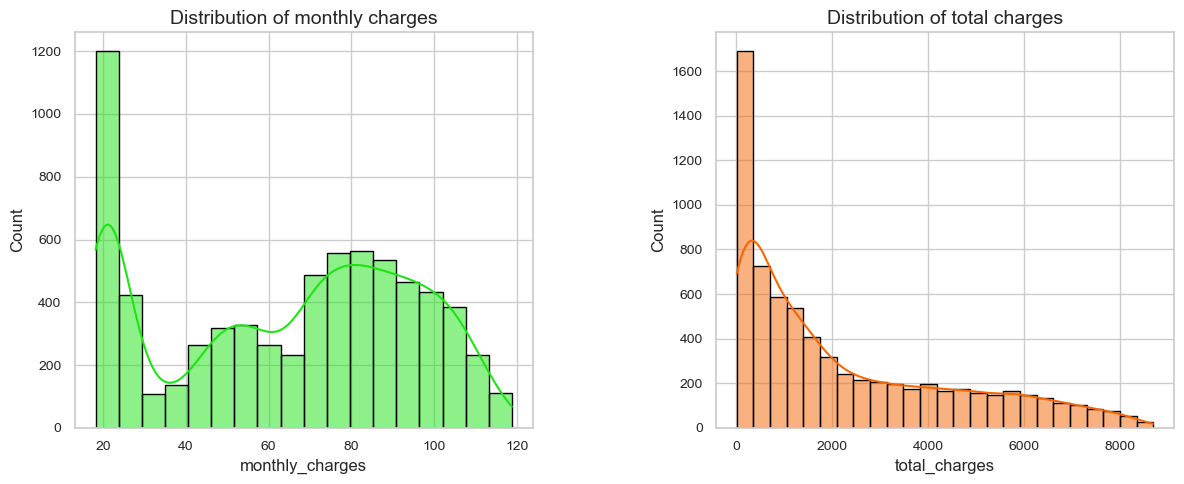

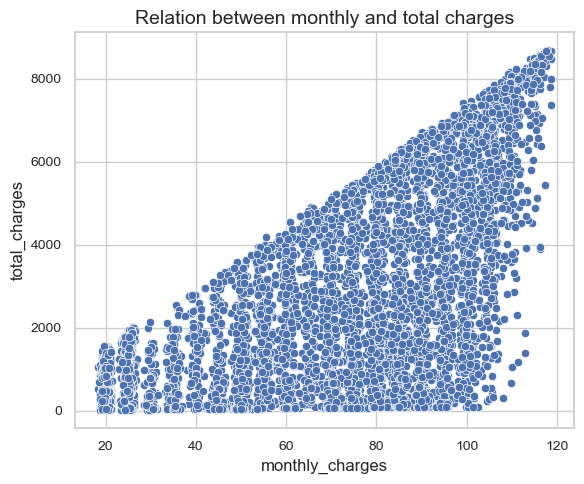

In [881]:
# Graph

# 1
columns = ['monthly_charges', 'total_charges']
titles  = ['Distribution of monthly charges', 'Distribution of total charges']
kind    = ['hist', 'hist']
data    = [customers_visual, customers_visual]
plots(data=data, columns=columns, kind=kind, titles=titles)

# 3
columns = [['monthly_charges', 'total_charges']]
titles  = ['Relation between monthly and total charges']     
kind    = ['scatter']
data    = customers_visual

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:**

- Los cargos mensuales van de 20 a 120 usd, y los cargos totales desde 0 hasta poco más de 8000 usd, en ambos caso los datos están sesgados hacia la derecha.

- En el caso de los cargos mensuales vemos un gran pico cerca de los 20 usd lo que quiere decir que la mayoria de los clientes optaron por los servicios más batos. Y por otro lado se ve otro pequeño mas pequeño pero mas estable grupo de clientes entre los 70 y 90 usd.

- Los cargos totales vemos entre mayor la factura menor el número de clientes.

- Vemos también una relación entre los cargos mensuales y totales, a mayor los cargos mensuales pueden estar siendo mayor lo cargos totales.

## - Cargos mensuales y totales entre diferentes grupos de clientes

Vamos a averiguar qué diferencias hay en los cargos mensuales o totales entre los clientes de acuerdo de su:
- género
- si es adulto mayor o no
- si tiene o no cargas familiares

### - Cargos mensuales y totales de clientes hombres y mujeres

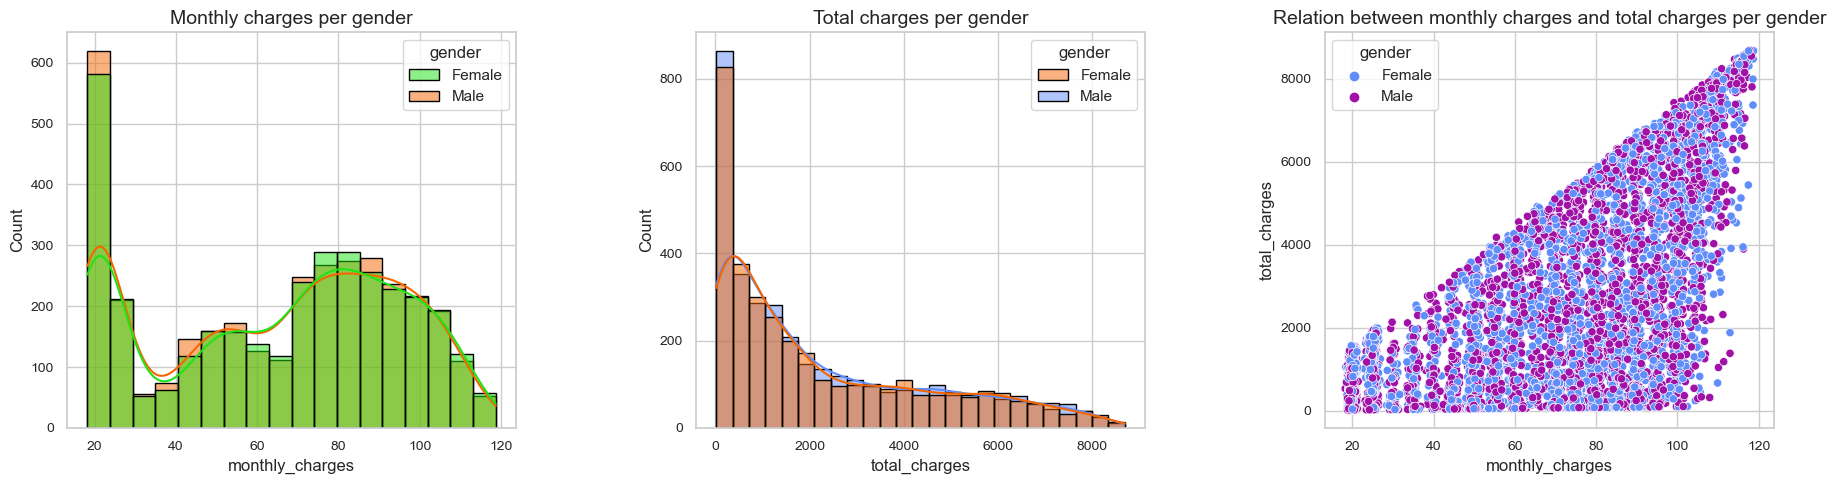

In [882]:
# Graph

columns = [['monthly_charges', 'gender'], ['total_charges', 'gender'], ['monthly_charges', 'total_charges', 'gender']]
titles  = ['Monthly charges per gender', 'Total charges per gender', 'Relation between monthly charges and total charges per gender']
kind    = ['hist', 'hist', 'scatter']
data    = [customers_visual, customers_visual, customers_visual]
plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:**

- No hay mayor diferencia de los cargos mensuales o totales entre hombres y mujeres.

### - Cargos mensuales y totales de clientes que son adultos mayores y no adultos mayores

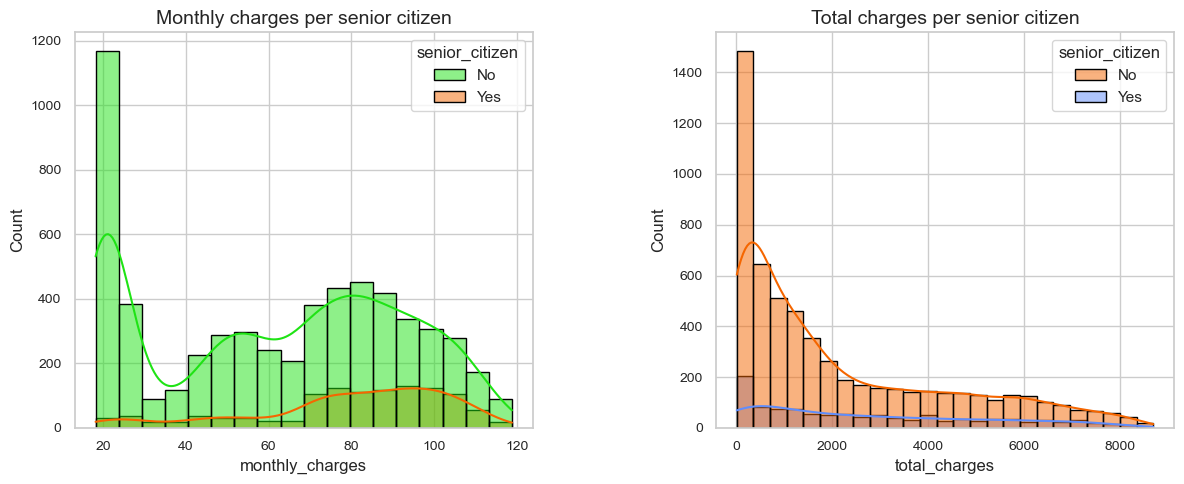

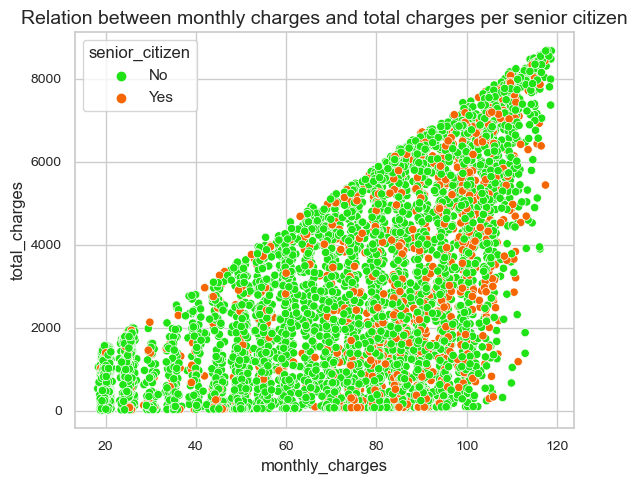

In [883]:
# Graph

columns = [['monthly_charges', 'senior_citizen'], ['total_charges', 'senior_citizen']]
titles  = ['Monthly charges per senior citizen', 'Total charges per senior citizen']
kind    = ['hist', 'hist']
data    = [customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

# ---------------------------------------------------------------------------------

columns = [['monthly_charges', 'total_charges', 'senior_citizen']]
titles  = ['Relation between monthly charges and total charges per senior citizen']     
kind    = ['scatter']

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:** 

- La mayoría de clientes adultos mayores pagan entre 80 y 100 usd mensualmente, y en minoría pagan menos de 60 usd. 
- Además la mayoría de clientes adultos mayores pagan cerca de los 150 usd anualmente, entre más alto es el pago hay menos clientes.

### - Cargos mensuales y totales entre clientes con o cargas familiares

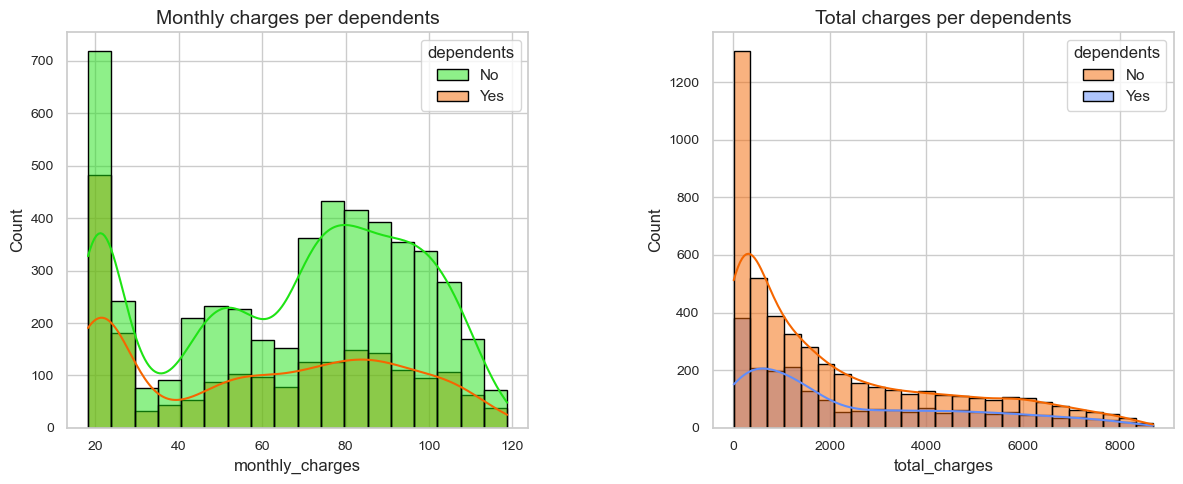

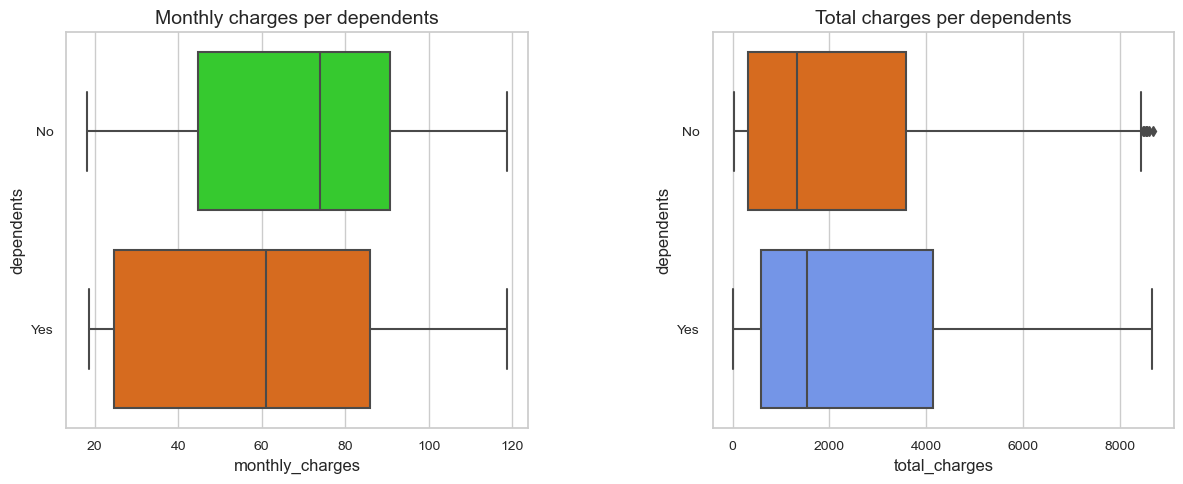

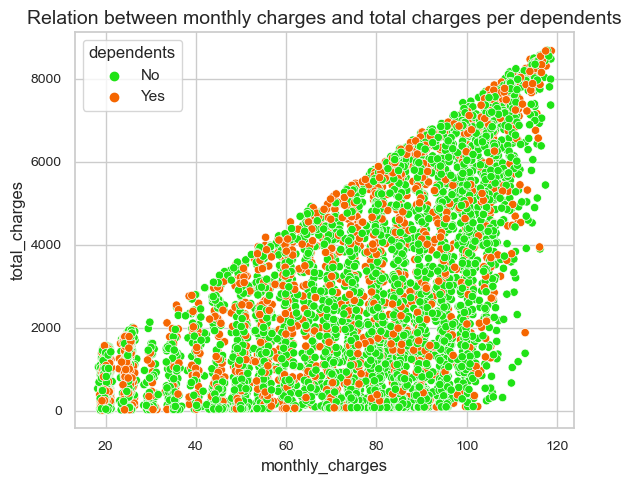

In [884]:
# Graph

columns = [['monthly_charges', 'dependents'], ['total_charges', 'dependents']]
titles  = ['Monthly charges per dependents', 'Total charges per dependents']
kind    = ['hist', 'hist']
data    = [customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

# -------------------------------------------------------------------------

kind    = ['boxplot', 'boxplot']

plots(data=data, columns=columns, kind=kind, titles=titles)

# -------------------------------------------------------------------------

columns = [['monthly_charges', 'total_charges', 'dependents']]
titles  = ['Relation between monthly charges and total charges per dependents']     
kind    = ['scatter']

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:** 

- La mayoría de clientes que tienen cargas familiares pagan entre 20-30 usd mensualmente y 80-90 usd.
- Además la mayoría de estos clientes anualmente pagan cerca de los 800 usd.
- Los clientes sin cargas familiares tienen un similar comportamiento en sus pagos mensuales/anuales respecto a los que si tienen cargas familiares.

## Métodos de pagos populares

Averiguemos, ¿qué métodos de pago son los más populares entre los clientes?

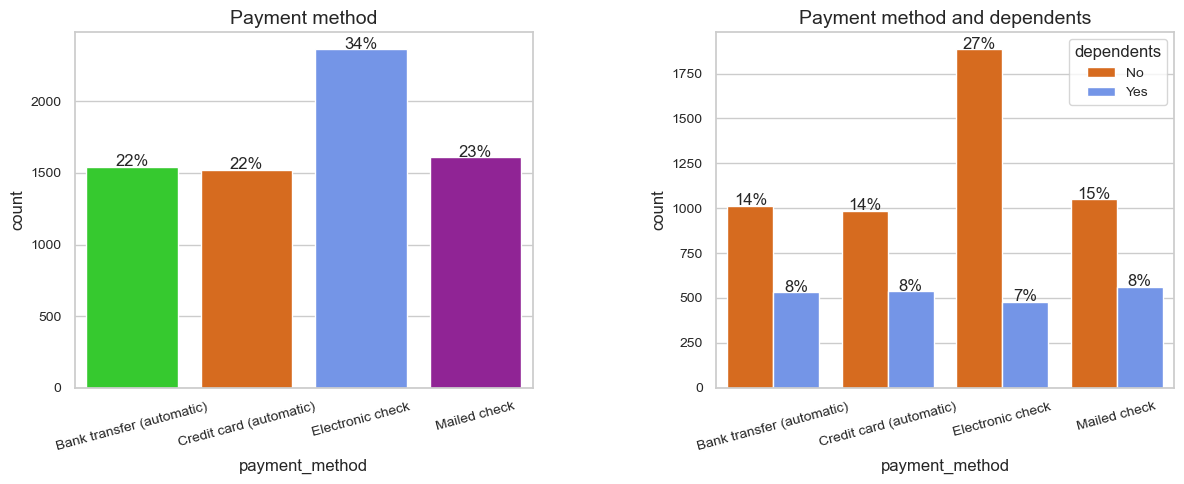

In [885]:
# Graph

columns = ['payment_method', ['payment_method','dependents']]
titles  = ['Payment method', 'Payment method and dependents']
kind    = ['count', 'count']
data    = [customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:** 

- El pago más pupular es con cheque electrónico (Electronic check) entre todos los clientes.
- Para los clientes que NO tienen cargas familiares, el cheque electrónico es el más usado; pero entre los clientes que SI tienen cargas familiares, los 4 métodos de pagos son favoritos.


## - Relación entre tipo de contrato y otros factores

- ¿Hay una relación entre el tipo de contrato y cargos mensuales? 
- ¿Hay una relación entre el tipo de contrato y método de pago o el uso de facturación electrónica?

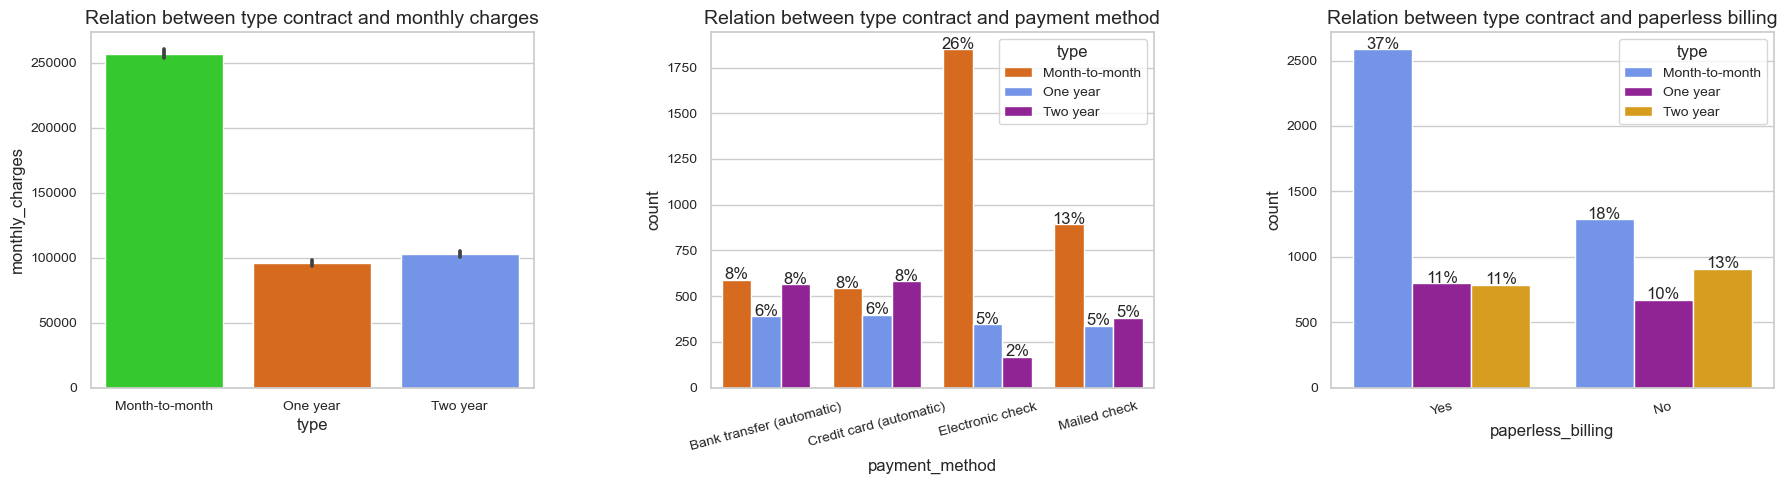

In [886]:
# Graph

columns = [['monthly_charges','type'],['payment_method','type'], ['paperless_billing','type']]
titles  = ['Relation between type contract and monthly charges','Relation between type contract and payment method', 'Relation between type contract and paperless billing']
kind    = ['bar','count','count']
data    = [customers_visual, customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:** 

- El tipo de contrato mes a mes es el preferido por los clientes. 
- La mayor parte de clientes que pagan mes a mes prefieren cheque electrónico.
- El tipo de contrato mes a mes es el preferido para quienes usan facturación electróncia.

## - ¿Qué servicios de internet son los más populares entre los clientes?


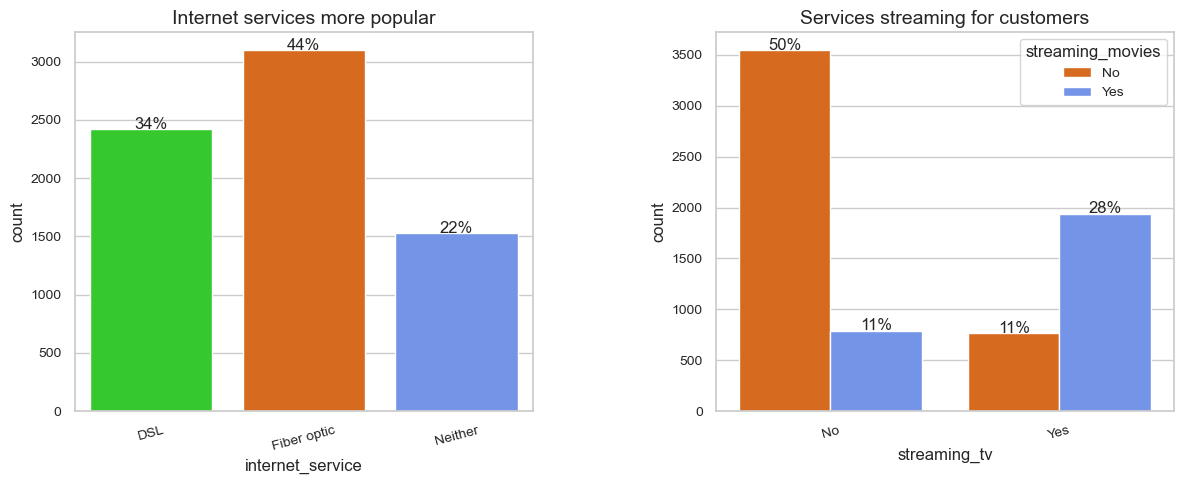

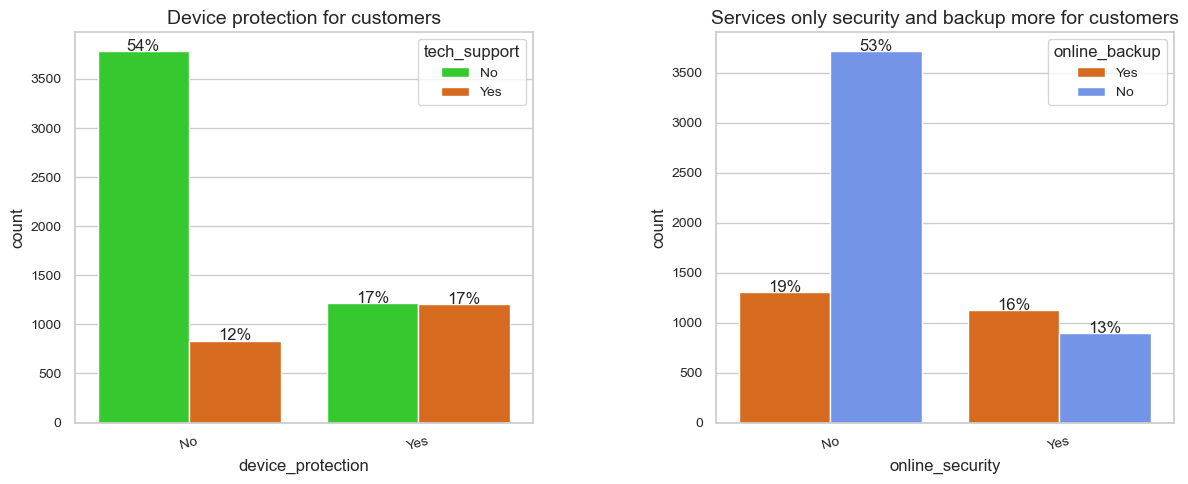

In [887]:
# Graph
columns = ['internet_service', ['streaming_tv', 'streaming_movies']]
titles  = ['Internet services more popular','Services streaming for customers']
kind    = ['count','count']
data    = [customers_visual, customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

# -------------------------------------------------------------------------

columns = [['device_protection','tech_support'], ['online_security', 'online_backup']]
titles  = ['Device protection for customers','Services only security and backup more for customers']
kind    = ['count','count']

plots(data=data, columns=columns, kind=kind, titles=titles)


**Análisis:**

- La fibra óptica es la más contratada por los clientes. La mitad de los clientes que tienen este servicio de fibra, no contrataron el servicio de internet aún.
- El 61% de clientes no contrató el servicio de streaming para TV ni de movies. En cambio, el 39% de clientes contrató el servicio de streaming para TV y de movies.
- El 66% de clientes no contrata el servicio de protección de dispositivos, solo el 34% lo hace. Por otro lado el 71% tampoco contraron el servicio de soporte técnico, solo el 29% lo hizo.
- El 72% de clientes no contrata los servicios de seguridad online y el 66% tampoco contrata el servicio de backup online.

### - ¿Hay alguna relación entre el uso de servicios de internet y otros factores como el género, la edad o el tipo de contrato?

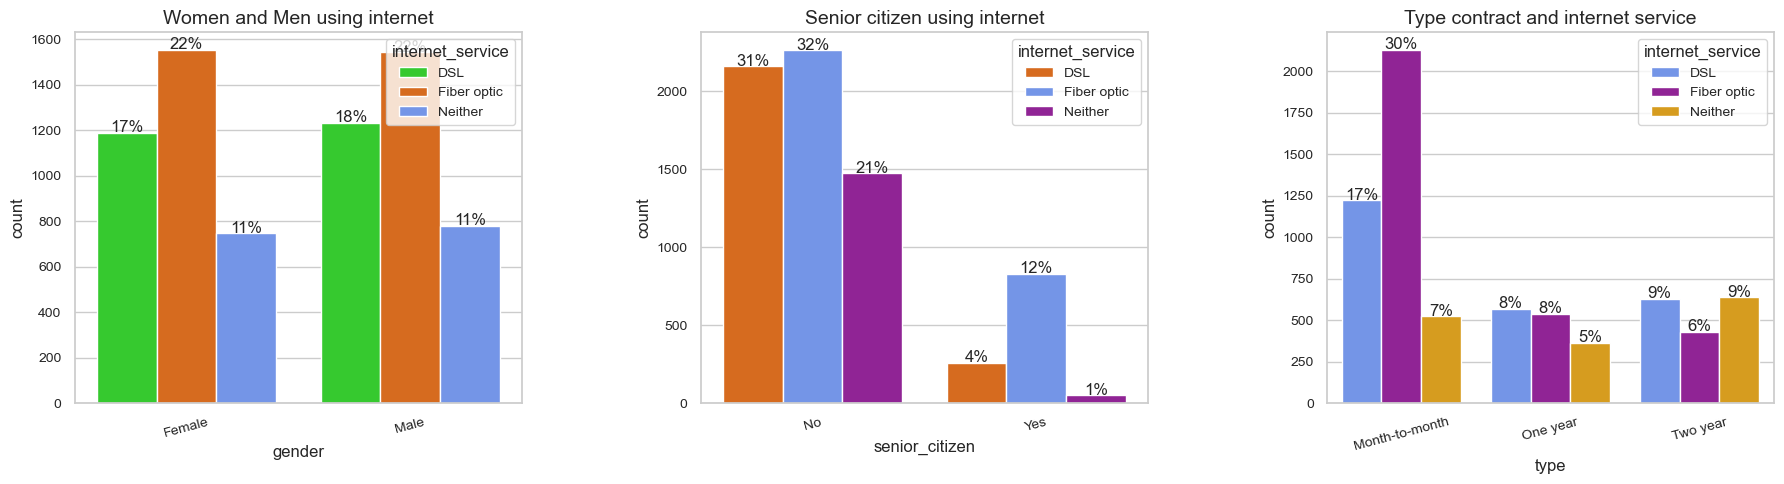

In [888]:
# Graph
columns = [['gender','internet_service'], ['senior_citizen','internet_service'], ['type','internet_service']]
titles  = ['Women and Men using internet', 'Senior citizen using internet', 'Type contract and internet service']
kind    = ['count','count', 'count']
data    = [customers_visual, customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:**
- Las preferencias entre DSL y fibra óptica de hombres y mujeres son muy parecidas.
- Entre los clientes adulto mayores, la mayoría usa fibra, y los que no son adultos mayor, usan tanto fibra como DSL.
- La fibra es muy popular para los clientes que tienen contrato mes a mes.

**Teniendo claro nuestro objetivo el cual será crea un modelo para saber qué clientes finalizarán contrato con la empresa, hay varias preguntas adicionales que podemos responder para prepararnos para el modelado. Vamos a descrubir:**

## - Clientes que se fueron

¿Qué porcentaje de clientes cancelaron el contrato con la empresa?

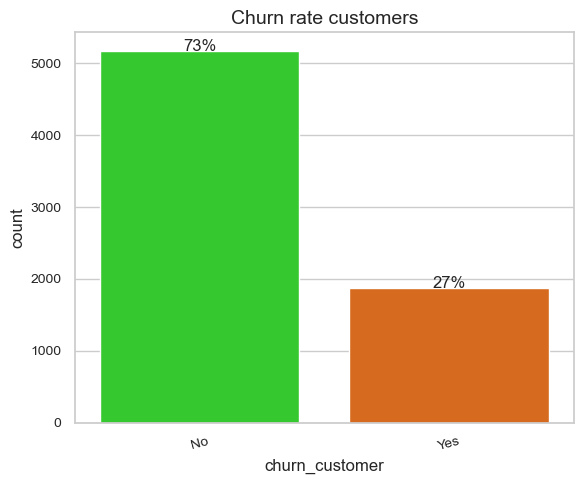

In [889]:
# Graph
columns = ['churn_customer']
titles  = ['Churn rate customers' ]
kind    = ['count']

plots(data=customers_visual, columns=columns, kind=kind, titles=titles)

**Análisis:**

Tenemos un 27% de clientes que finalizaron contrato con la empresa. A continuación revisaremos el comportamiento de este porcentaje de clientes que se fueron y qué patrones de comportamientos podemos encontrar en los datos.

## - Grupos de clientes y su tasa de cancelación

¿Hay diferencias en la tasa de cancelación o finalización del contrato entre diferentes grupos de clientes, como por ejemplo entre hombres y mujeres, adultos  mayores y no adultos mayores, o entre aquellos con o sin dependientes?

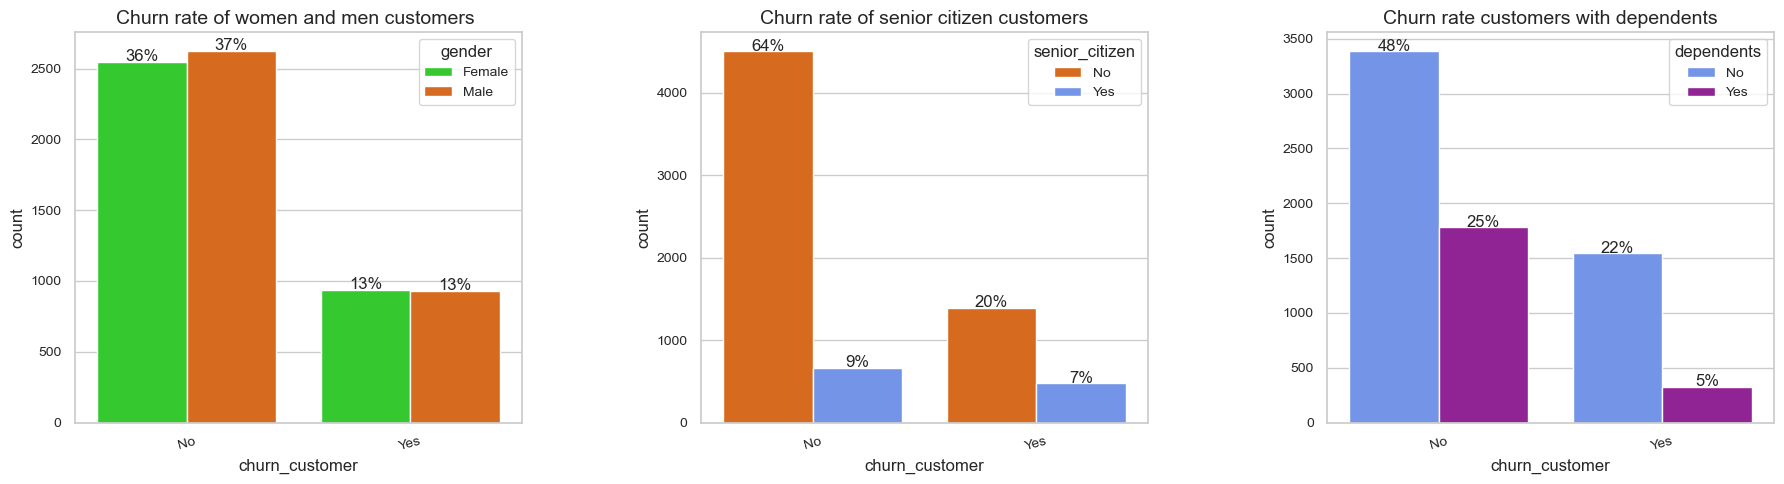

In [890]:
# Graph

columns = [['churn_customer','gender'], ['churn_customer','senior_citizen'], ['churn_customer','dependents']]
titles  = ['Churn rate of women and men customers ', 'Churn rate of senior citizen customers', 'Churn rate customers with dependents' ]
kind    = ['count', 'count', 'count']
data    = [customers_visual, customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:**
- De los clientes que se fueron eran proporcionalmente hombres y mujeres, es decir, no hay diferencias en géneros.
- De los clientes que se fueron la mayoría NO eran adultos mayores.
- De los clientes que se fueron la mayoría NO tenían cargas familiares.

## - Relación del tiempo de permanencia y fuga de clientes
¿Hay una relación entre el tiempo de permanencia (meses) y los clientes que deciden irse?

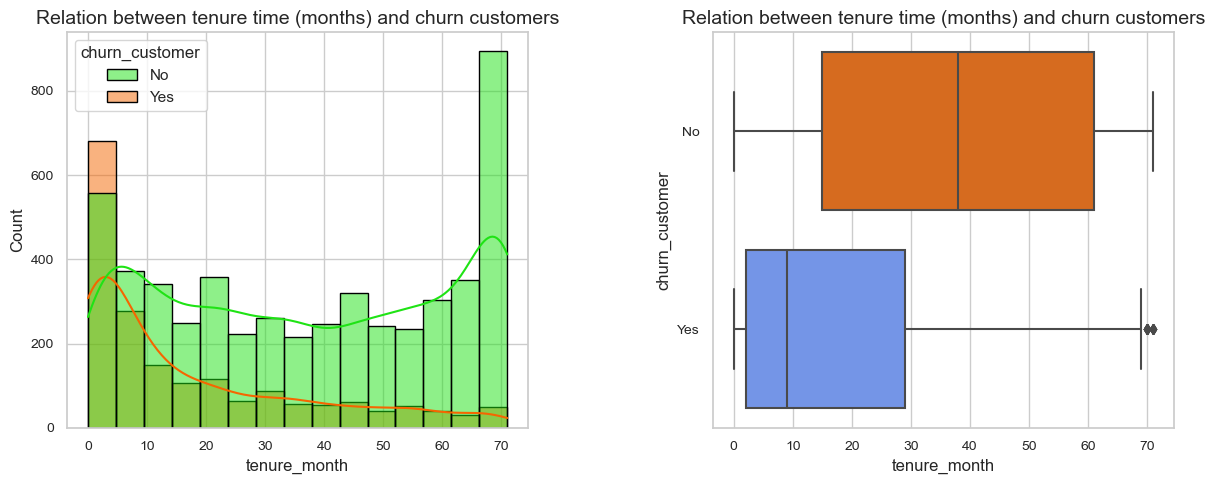

In [891]:
# Graph

columns = [['tenure_month', 'churn_customer'], [ 'tenure_month', 'churn_customer']]
titles  = ['Relation between tenure time (months) and churn customers', 'Relation between tenure time (months) and churn customers']
kind    = ['hist','boxplot']
data    = [customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:**
- De los clientes que se fueron la mayor parte tenían entre 0 a 10 meses de permanencia en el contrato. Hay una minoría (atípica) que tenía un tiempo de permanencia mayor a 70 meses.

## - Factores más fuertes que inciden en la fuga de clientes
¿Qué factores están más fuertemente asociados con la cancelación o finalización del contrato? Por ejemplo, ¿los clientes que usan facturación electrónica ("paperless_billing") tienen más o menos probabilidades de cancelar sus contratos que aquellos que no lo hacen?

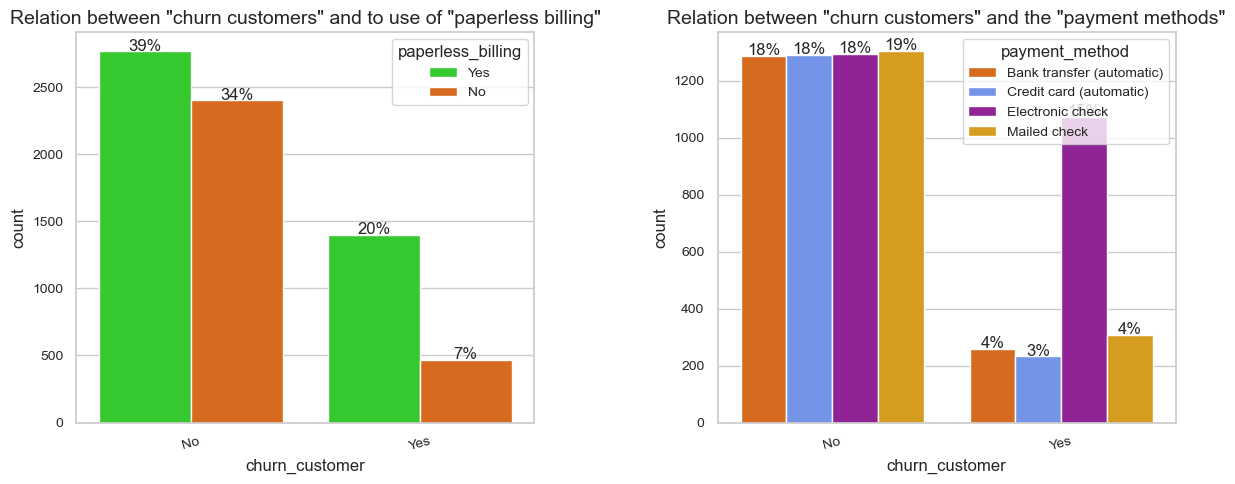

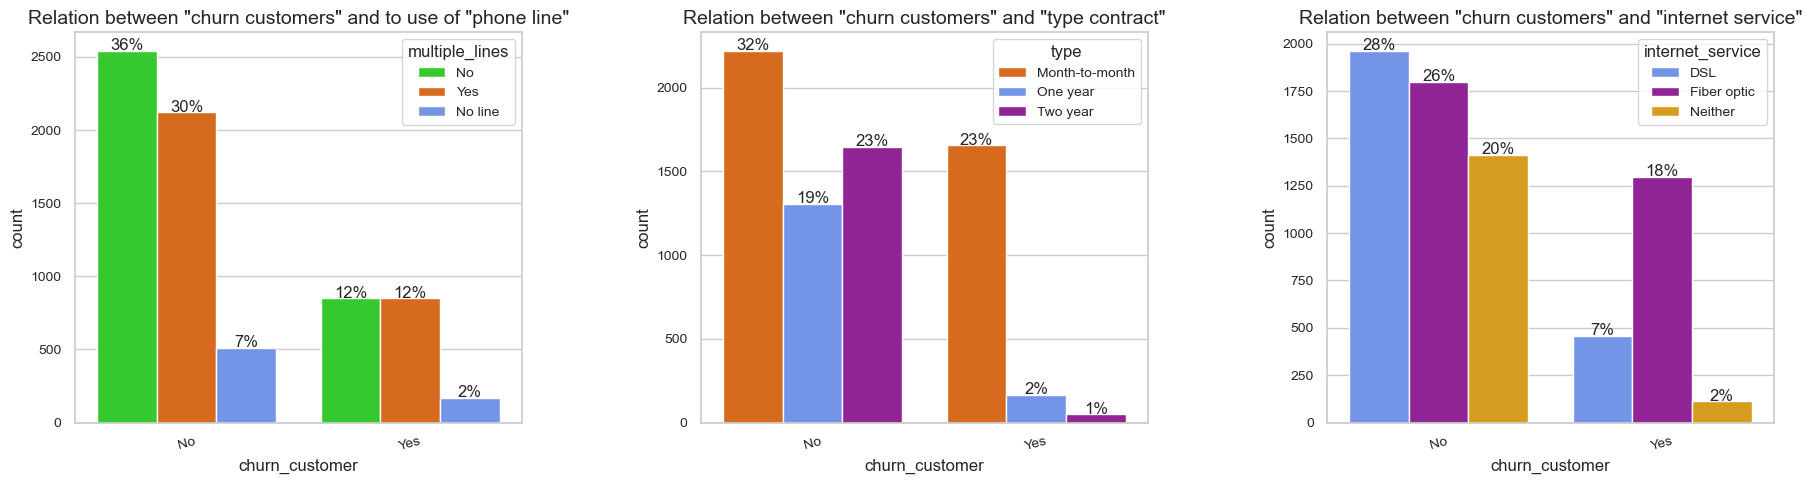

In [892]:
# Graph

columns = [['churn_customer', 'paperless_billing'], [ 'churn_customer', 'payment_method']]
titles  = ['Relation between "churn customers" and to use of "paperless billing"', 'Relation between "churn customers" and the "payment methods"']
kind    = ['count', 'count']
data    = [customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

# -------------------------------------------------------------------------

columns = [['churn_customer',  'multiple_lines'], ['churn_customer', 'type'], ['churn_customer', 'internet_service']]
titles  = ['Relation between "churn customers" and to use of "phone line"', 'Relation between "churn customers" and "type contract"',
           'Relation between "churn customers" and "internet service"']
kind    = ['count', 'count', 'count']
data    = [customers_visual, customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:**
- De los clientes que se fueron la mayoría contaba con facturación electrónica.
- De los clientes que se fueron la mayoría pagaba mediante cheque electróncio.
- De los clientes que se fueron la mayoría tenía contratada una o más líneas telefónicas.
- De los clientes que se fueron la mayoría pagaba mes a mes la factura.
- De los clientes que se fueron la mayoría usaba fibra.

## - Relación entre el uso de servicios de internet y fuga de clientes
¿Hay alguna relación entre el uso de servicios de internet (`internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`) y la finalización del contrato?

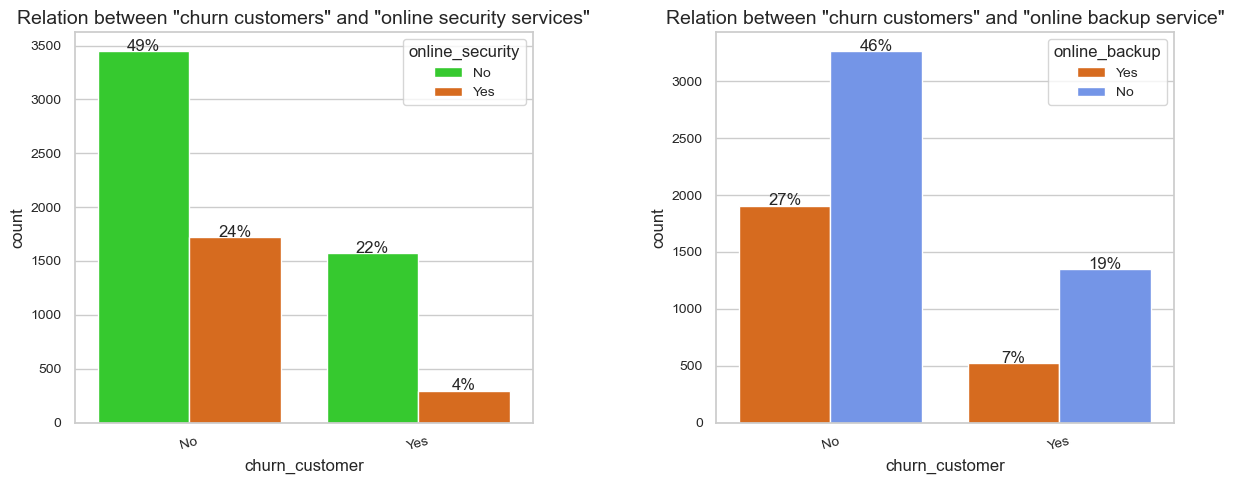

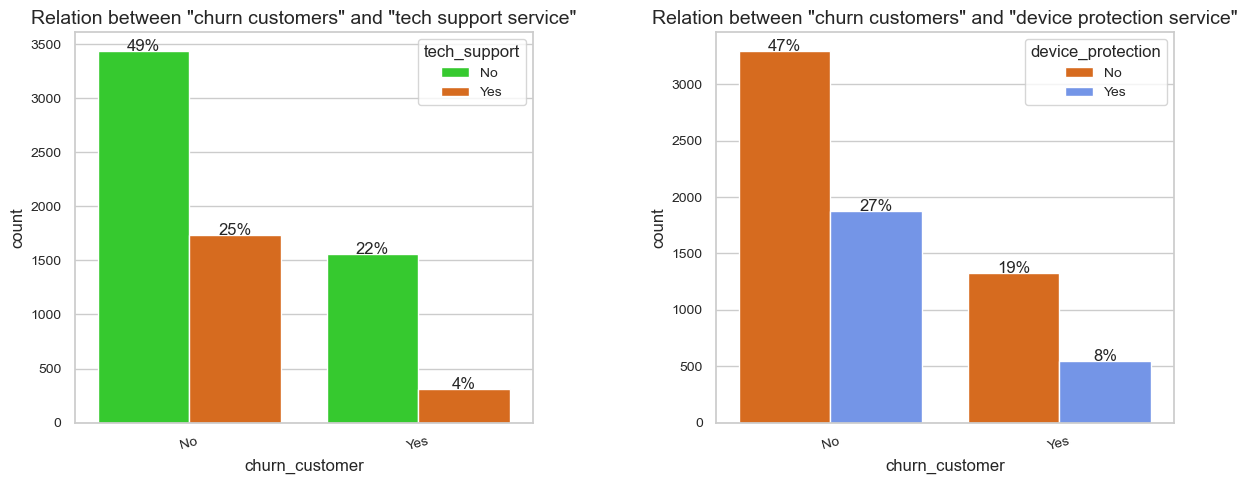

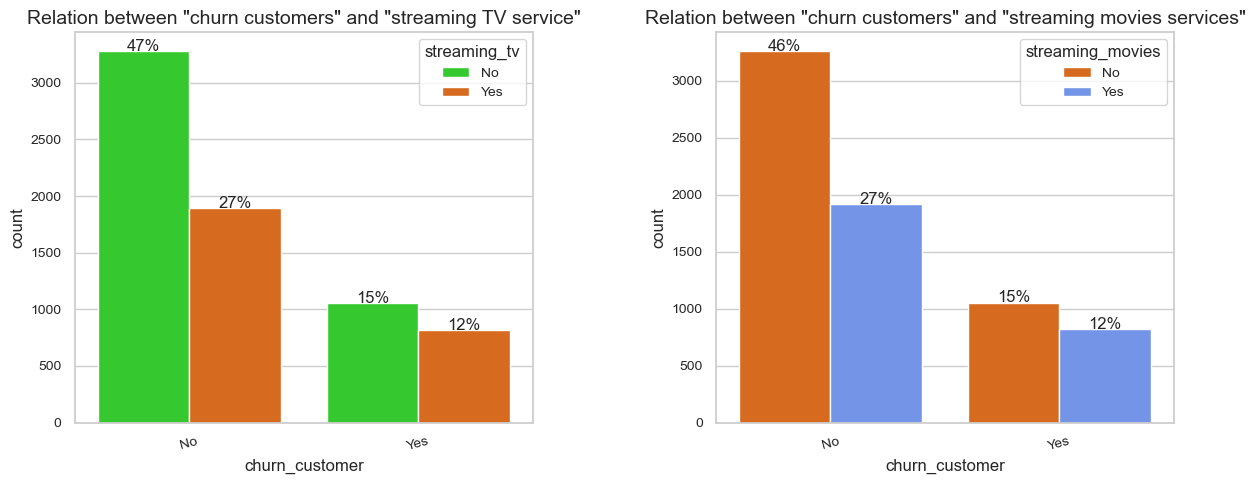

In [893]:
columns = [['churn_customer',  'online_security'], ['churn_customer', 'online_backup']]
titles  = ['Relation between "churn customers" and "online security services"', 'Relation between "churn customers" and "online backup service"']
kind    = ['count', 'count']
data    = [customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

# -------------------------------------------------------------------------

columns = [['churn_customer',  'tech_support'], ['churn_customer', 'device_protection']]
titles  = ['Relation between "churn customers" and "tech support service"', 'Relation between "churn customers" and "device protection service"']

plots(data=data, columns=columns, kind=kind, titles=titles)

# -------------------------------------------------------------------------

columns = [['churn_customer',  'streaming_tv'], ['churn_customer', 'streaming_movies']]
titles  = ['Relation between "churn customers" and "streaming TV service"', 'Relation between "churn customers" and "streaming movies services"']

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis:**
- No se ven relaciones entre el uso de servicios y el abandono de clientes, ya que el comportamiento para los clientes que se fueron y los que aún siguen en la empresa es parecido.

## Análisis de correlaciones

Vamos a analizar visualizando los valores de correlación entre las variables. Los valores pueden variar entre -1 y 1, donde -1 indica una correlación negativa perfecta, 0 indica que no hay correlación y 1 indica una correlación positiva perfecta.

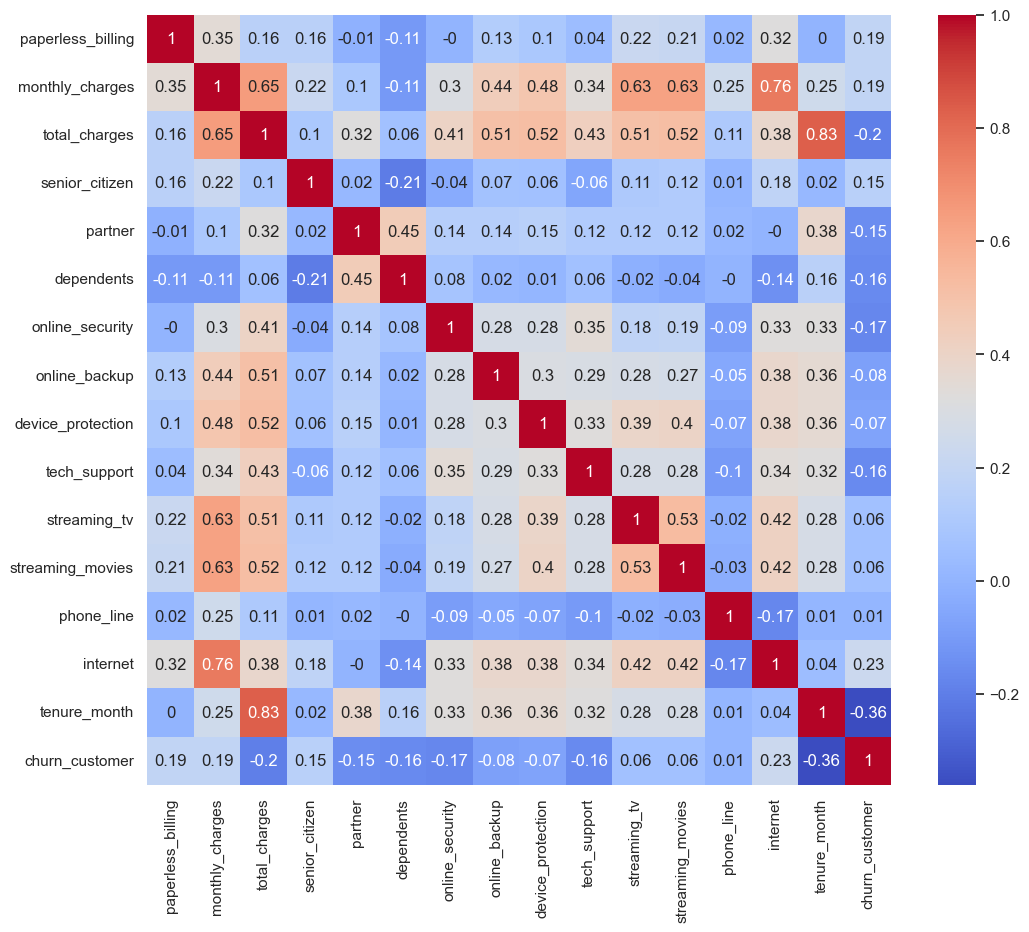

In [894]:
# All customers

corr = round(customers.corr(numeric_only=True),2)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm');

Observamos 2 correlaciones lineales: cargos mensuales e internet, cargos totales y meses de permanencia. Grafiquemos:

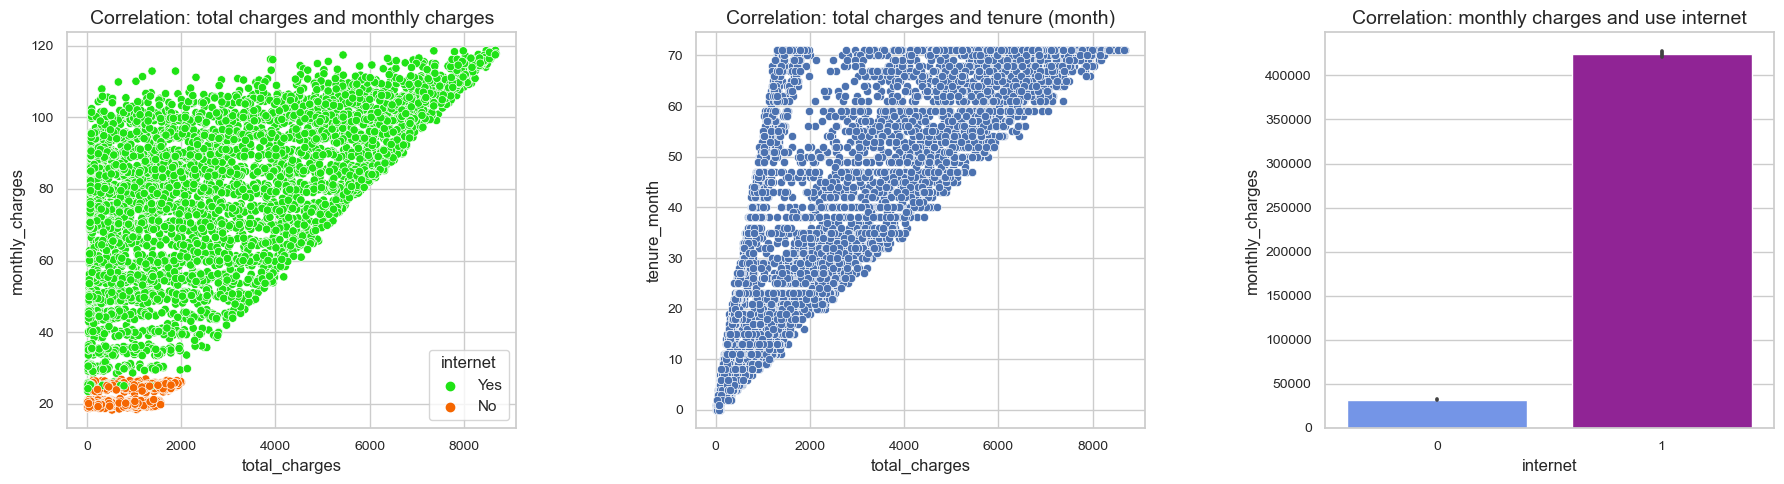

In [895]:
columns = [['total_charges', 'monthly_charges', 'internet'],
           ['total_charges', 'tenure_month'],
           ['monthly_charges','internet']]

titles  = ['Correlation: total charges and monthly charges',
           'Correlation: total charges and tenure (month)',
           'Correlation: monthly charges and use internet']   
  
kind    = ['scatter','scatter','bar']
data    = [customers_visual, customers_visual, customers_visual]

plots(data=data, columns=columns, kind=kind, titles=titles)

**Análisis de todos los clientes**:

*Correlación entre el total de cargos y cargos mensuales y meses de permanencia*
- La variable `total_charges` tiene una **fuerte correlación positiva** con `monthly_charges` y `tenure_month`. A mayor cargos totales, mayor cargos mensuales y mayor tiempo de permanencia del cliente.

*Correlación entre cargos totales y contratación de internet*
- La variable `monthly_charges` tiene una **fuerte correlación positiva** fuerte con `internet`. A mayor el cargo total, mayor probabilidad de que el cliente tenga contratado internet.

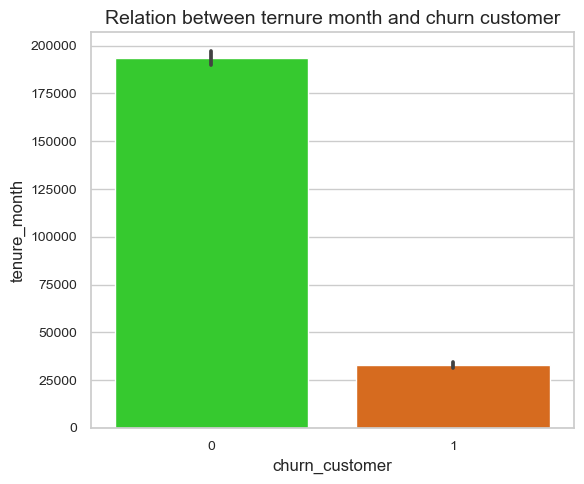

In [896]:
# Correlation target with tenure
columns = [['tenure_month', 'churn_customer']]
titles  = ['Relation between ternure month and churn customer']     
kind    = ['bar']
data    = customers

plots(data=data, columns=columns, kind=kind, titles=titles)

La variable `churn_customer` (target) *no tiene relaciones lineales fuertes* con las características de los clientes. Se observan relaciones lineales muy débiles con `tenure_month` (negativa):
- Las variables que tienen una correlación negativa con `churn_customer` son posibles factores que favorecen la retención de los clientes. En este caso, un cliente que lleva más tiempo con la empresa puede tener menos probabilidad de abandonarla. En otras palabras, los clientes que se fueron tenían poco tiempo de permanencia con su contrato.

# Procesamiento de datos <a id='pro'></a>

En esta sección aplicaremos técnicas de procesamiento de caracteristicas para que nuestro modelo tenga mejor calidad. 

Realizaremos las siguientes acciones:
- Codificar columnas categóricas 
- Segmentar de datos
- Revisar y/o tratar valores atípicos
- Escalar características numéricas
- Equilibrar las clases
- Elección de características

Antes que todo, identificaremos las características "X" y objetivo "y" para nuestros modelos. En las características colocaremos todas la información del clientes a excepción de las fechas, el id del cliente y nuestra variable objetivo. La variable objetivo es "churn_customer".

In [897]:
# identify X = features and y = target

X = customers.drop(['begin_date','customer_id','end_date','churn_customer'], axis=1)
y = customers['churn_customer']
print(f'features X={X.shape}, target y={y.shape}')

features X=(7043, 20), target y=(7043,)


## Codificar caracteristicas con One-Hot Encoder

Para codificar nuestras características categóricas, usaremos `OneHotEncoder` de scikit-learn, y estableceremos varios parámetros en nuestra instancia OneHotEncoder:
- `sparse_output` = `False`: Devolverá una matriz dispersa si se establece en True; de ​​lo contrario, devolverá una matriz.
- `drop` = `'first'`: elimina la primera categoría en cada función. Si solo hay una categoría presente, la función se eliminará por completo.
- `handle_unknown` = `'ignore'`: Las categorías desconocidas se ignoran durante la transformación. No se genera ningún error.

In [898]:
X.head(2)

type  paperless_billing    payment_method  monthly_charges  \
0  Month-to-month                  1  Electronic check            29.85   
1        One year                  0      Mailed check            56.95   

   total_charges  gender  senior_citizen  partner  dependents  \
0          29.85  Female               0        1           0   
1        1889.50    Male               0        0           0   

  internet_service  online_security  online_backup  device_protection  \
0              DSL                0              1                  0   
1              DSL                1              0                  1   

   tech_support  streaming_tv  streaming_movies multiple_lines  phone_line  \
0             0             0                 0        No line           0   
1             0             0                 0             No           1   

   internet  tenure_month  
0         1             1  
1         1            34

In [899]:
# Select categorical characteristics
col_cat = X.select_dtypes(include=['category']).columns.tolist()
col_cat

['type', 'payment_method', 'gender', 'internet_service', 'multiple_lines']

In [900]:
# Apply OneHotEncoder for categorical features

ohe = OneHotEncoder(sparse_output=False, 
                    handle_unknown='ignore',
                    drop='first')

col_ohe = ohe.fit_transform(X[col_cat])

# Transform to dataframe the OHE features
X_ohe = pd.DataFrame(data=col_ohe, columns=ohe.get_feature_names_out()).astype(int)

# Remove categorical columns "cat_col" in features
X.drop(labels=col_cat, axis=1, inplace=True)

# Add OHE features transformed into "X" features
X = X.merge(right=X_ohe, left_index=True, right_index=True)
X

paperless_billing  monthly_charges  total_charges  senior_citizen  \
0                     1            29.85          29.85               0   
1                     0            56.95        1889.50               0   
2                     1            53.85         108.15               0   
3                     0            42.30        1840.75               0   
4                     1            70.70         151.65               0   
...                 ...              ...            ...             ...   
7038                  1            84.80        1990.50               0   
7039                  1           103.20        7362.90               0   
7040                  1            29.60         346.45               0   
7041                  1            74.40         306.60               1   
7042                  1           105.65        6844.50               0   

      partner  dependents  online_security  online_backup  device_protection  \
0           1           0                0              1                  0   
1           0           0                1              0                  1   
2           0           0                1              1                  0   
3           0           0                1              0                  1   
4           0           0                0              0                  0   
...       ...         ...              ...            ...                ...   
7038        1           1                1              0                  1   
7039        1           1                0              1                  1   
7040        1           1                1              0                  0   
7041        1           0                0              0                  0   
7042        0           0                1              0                  1   

      tech_support  ...  type_One year  type_Two year  \
0                0  ...              0              0   
1                0  ...              1              0   
2                0  ...              0              0   
3                1  ...              1              0   
4                0  ...              0              0   
...            ...  ...            ...            ...   
7038             1  ...              1              0   
7039             0  ...              1              0   
7040             0  ...              0              0   
7041             0  ...              0              0   
7042             1  ...              0              1   

      payment_method_Credit card (automatic)  payment_method_Electronic check  \
0                                          0                                1   
1                                          0                                0   
2                                          0                                0   
3                                          0                                0   
4                                          0                                1   
...                                      ...                              ...   
7038                                       0                                0   
7039                                       1                                0   
7040                                       0                                1   
7041                                       0                                0   
7042                                       0                                0   

      payment_method_Mailed check  gender_Male  internet_service_Fiber optic  \
0                               0            0                             0   
1                               1            1                             0   
2                               1            1                             0   
3                               0            1                             0   
4                               0            0                             1   
...   

Hemos transformado nuestras `X` removiendo las variables categóricas y agregando las variables codificadas.
- Removidas: 
    - 'type', 
    - 'payment_method', 
    - 'gender', 
    - 'internet_service', 
    - 'multiple_lines'
    
- Agregadas: 
    - 'type_One year', 'type_Two year',
    - 'payment_method_Credit card (automatic)', 'payment_method_Electronic check', 'payment_method_Mailed check',
    - 'gender_Male', 
    - 'internet_service_Fiber optic', 'internet_service_Neither', 
    - 'multiple_lines_No line', 'multiple_lines_Yes'


## Elección de características

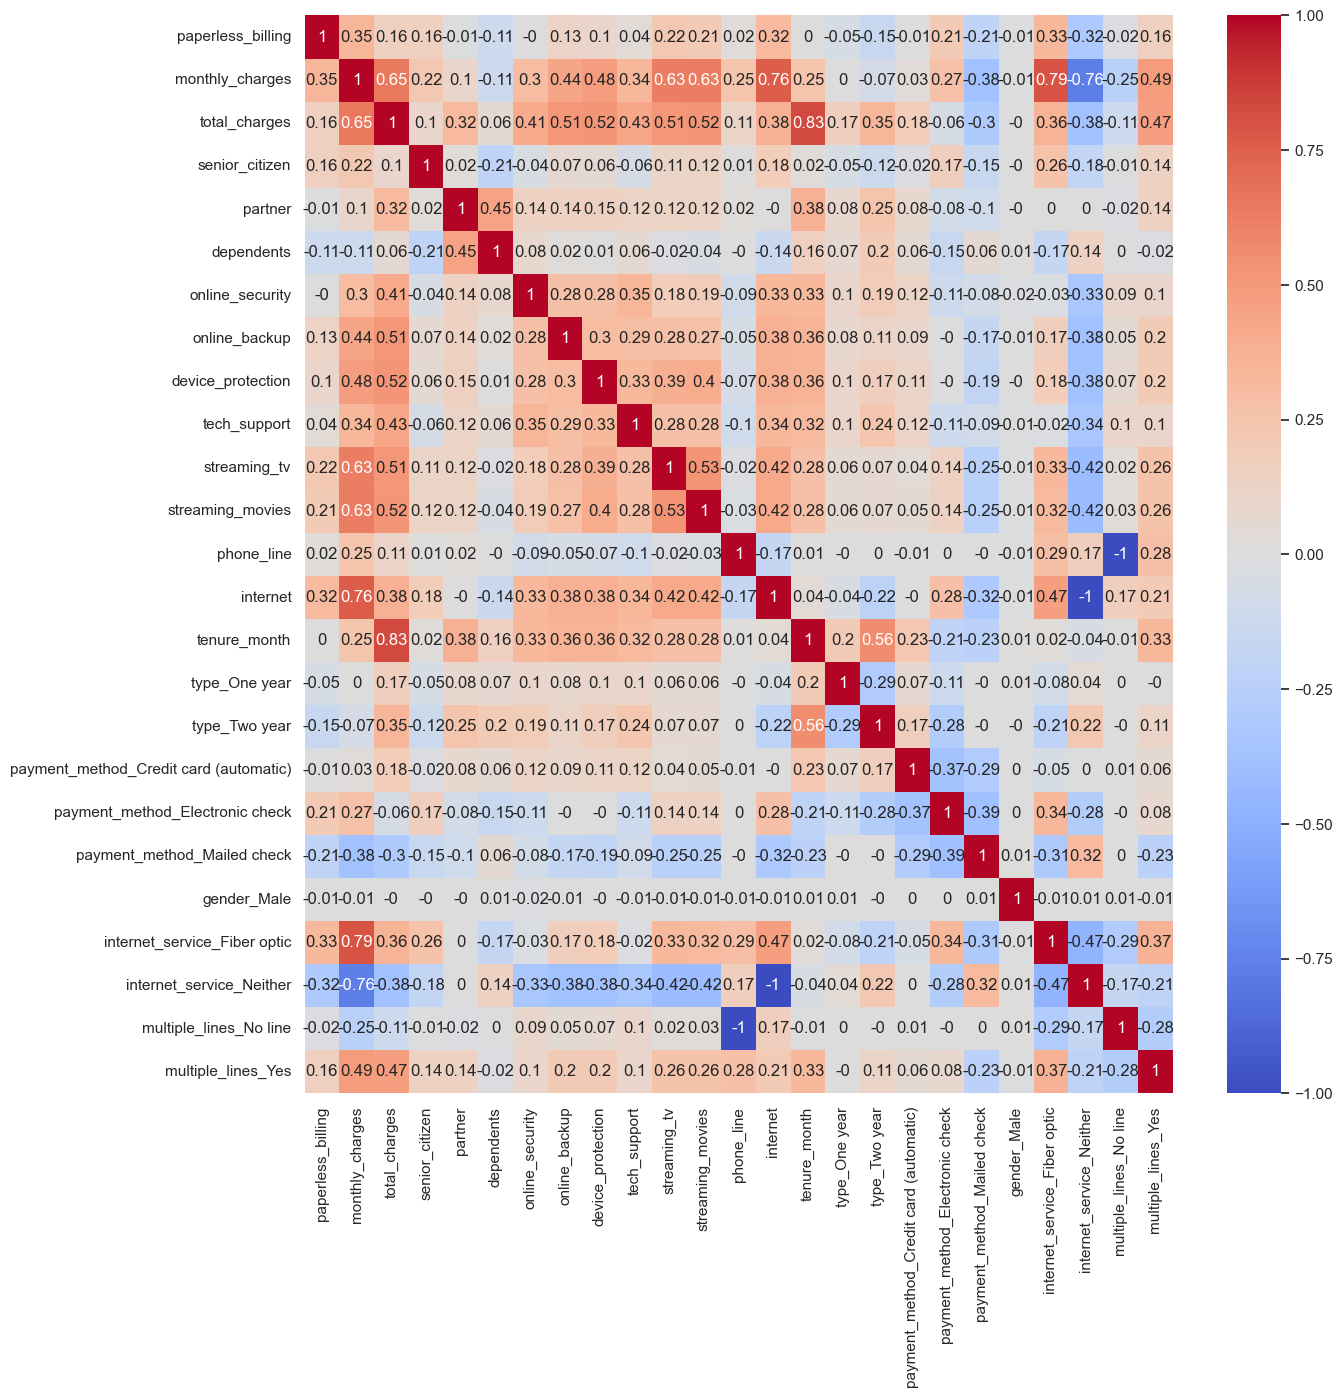

In [901]:
# Calculate correlation matrix
corr_matrix = round(X.corr(),2)
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

In [902]:
# Select features with a correlation less than 0.90
selected_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            selected_features.append(colname)

# Crear un nuevo DataFrame con las características seleccionadas
print('Features to remove: ', selected_features)
X = X.drop(selected_features, axis=1)
display(X.shape)

Features to remove:  ['internet_service_Neither', 'multiple_lines_No line']


(7043, 23)

In [903]:
X.columns

Index(['paperless_billing', 'monthly_charges', 'total_charges',
       'senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'phone_line', 'internet', 'tenure_month',
       'type_One year', 'type_Two year',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'gender_Male', 'internet_service_Fiber optic', 'multiple_lines_Yes'],
      dtype='object')

Tal como hemos observado en el mapa de calor de nuestras correlaciones y basándonos en un umbral mayor a 0.90 decidimos eliminar las características:
- '`internet_service_Neither`', 
- '`multiple_lines_No line`'.

## Segmentación datos

Segmentaremos los datos en entrenamiento / prueba / validación con proporciones en proporciones 70/15/15 correspondientemente. 
- entrenamiento `X_train`, `y_train`, 
- prueba `X_test`, `y_test` y 
- validación `X_valid`, `y_valid`

In [904]:
# Split: train 70% / test 15% / valid 15%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=12345)
print('train:', X_train.shape, y_train.shape)
print('test: ', X_test.shape, y_test.shape)
print('valid:', X_valid.shape, y_valid.shape)

train: (4930, 23) (4930,)
test:  (1056, 23) (1056,)
valid: (1057, 23) (1057,)


## Outliers

Vamos a verificar si existen valores atípicos en las columnas numéricas: 'monthly_charges', 'total_charges', 'tenure_month', en los datos de entrenamiento 'X_train'

Usaremos la función `find_outliers` para realizar la comprobación. En el caso de no existir valores atípicos, continuaremos con el escalado, caso contrario, removeremos los outliers.

In [905]:
# function "find_outliers"

def outliers(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    min = (Q1 - 1.5 * IQR).astype('int')
    max = (Q3 + 1.5 * IQR).astype('int')

    indexes = df[(df[col] <= min) | (df[col] >= max)].index

    return indexes

In [906]:
# Numerical features 
col_numeric = ['monthly_charges', 'total_charges', 'tenure_month']

# finding outliers
for col in col_numeric:
    print(f'Column "{col}" {len(outliers(X_train, col))} ouliers')

Column "monthly_charges" 0 ouliers
Column "total_charges" 0 ouliers
Column "tenure_month" 0 ouliers


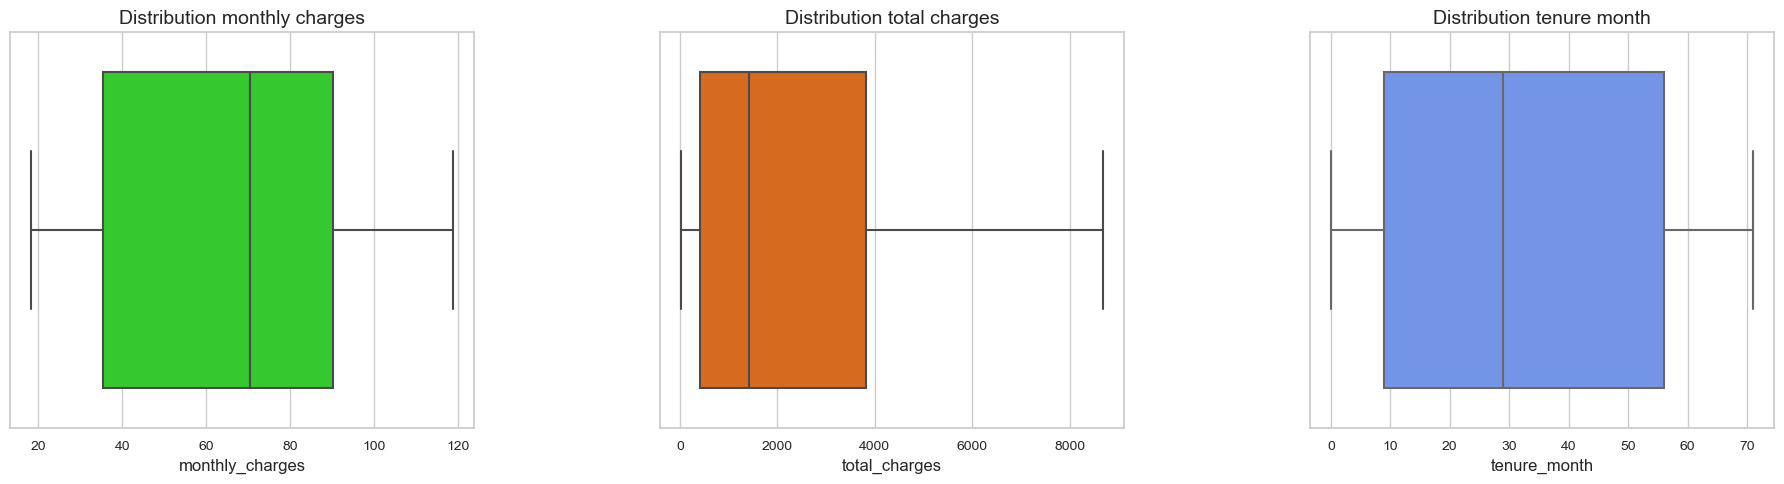

In [907]:
columns  = ['monthly_charges', 'total_charges', 'tenure_month' ]   
titles = ['Distribution monthly charges', 'Distribution total charges', 'Distribution tenure month' ]
kind    = ['boxplot', 'boxplot', 'boxplot']
data    = [X_train, X_train, X_train]

plots(data=data, columns=columns, kind=kind, titles=titles)

Hemos comprobado y además visualizado en nuestros gráficos de caja y bigotes que no existen valores atípicos en las 3 variables numéricas.

## Escalar características:

Las variables 'monthly_charges', 'total_charges', 'tenure_month', tienen diferentes escalas como vemos en las siguientes estadísticas a continuación, por lo que vamos usar ***MinMaxScaler***, el cual reescalará el conjunto de datos de tal manera que todos los valores de las 3 variables estarán en el rango [0, 1]. Este escalador es sensible a la presencia de valores atípicos, pero como comprobamos en el apartado anterior, no tenemos outliers.

Realizaremos lo siguiente:
- ajustar el escalador a los datos de entrenamiento por medio del `fit`.
- aplicaremos el escalado a los datos de entrenamiento, prueba y validación, por medio del `tranform`.

In [908]:
print(X_train[col_numeric].describe()), print(line)
print( X_test[col_numeric].describe()), print(line)
print(X_valid[col_numeric].describe())

       monthly_charges  total_charges  tenure_month
count      4930.000000    4930.000000   4930.000000
mean         64.802201    2301.624645     32.460649
std          30.218527    2265.216082     24.420867
min          18.250000      18.850000      0.000000
25%          35.287500     412.525000      9.000000
50%          70.300000    1416.025000     29.000000
75%          90.150000    3823.762500     56.000000
max         118.750000    8684.800000     71.000000
       monthly_charges  total_charges  tenure_month
count      1056.000000    1056.000000   1056.000000
mean         65.392330    2325.315388     32.388258
std          29.645479    2304.153921     24.741255
min          18.700000      19.300000      0.000000
25%          43.200000     410.650000      8.750000
50%          71.275000    1389.800000     29.000000
75%          89.075000    3894.712500     55.250000
max         118.650000    8547.150000     71.000000
       monthly_charges  total_charges  tenure_month
count      1

In [909]:
# backup of unscaled data
X_train_unscaled = X_train.copy()
X_test_unscaled  = X_test.copy()
X_valid_unscaled  = X_test.copy()

In [910]:
# Scaling
scaler = MinMaxScaler()
scaler.fit(X_train[col_numeric])

# transform
X_train[col_numeric] = scaler.transform(X_train[col_numeric])
X_test[col_numeric]  = scaler.transform(X_test[col_numeric])
X_valid[col_numeric] = scaler.transform(X_valid[col_numeric])

In [911]:
# Descriptive statistics after scaling

print(X_train[col_numeric].describe()), print(line)
print( X_test[col_numeric].describe()), print(line)
print(X_valid[col_numeric].describe())

       monthly_charges  total_charges  tenure_month
count      4930.000000    4930.000000   4930.000000
mean          0.463206       0.263419      0.457192
std           0.300682       0.261393      0.343956
min           0.000000       0.000000      0.000000
25%           0.169527       0.045428      0.126761
50%           0.517910       0.161226      0.408451
75%           0.715423       0.439065      0.788732
max           1.000000       1.000000      1.000000
       monthly_charges  total_charges  tenure_month
count      1056.000000    1056.000000   1056.000000
mean          0.469078       0.266153      0.456173
std           0.294980       0.265886      0.348468
min           0.004478       0.000052      0.000000
25%           0.248259       0.045211      0.123239
50%           0.527612       0.158200      0.408451
75%           0.704726       0.447252      0.778169
max           0.999005       0.984116      1.000000
       monthly_charges  total_charges  tenure_month
count      1

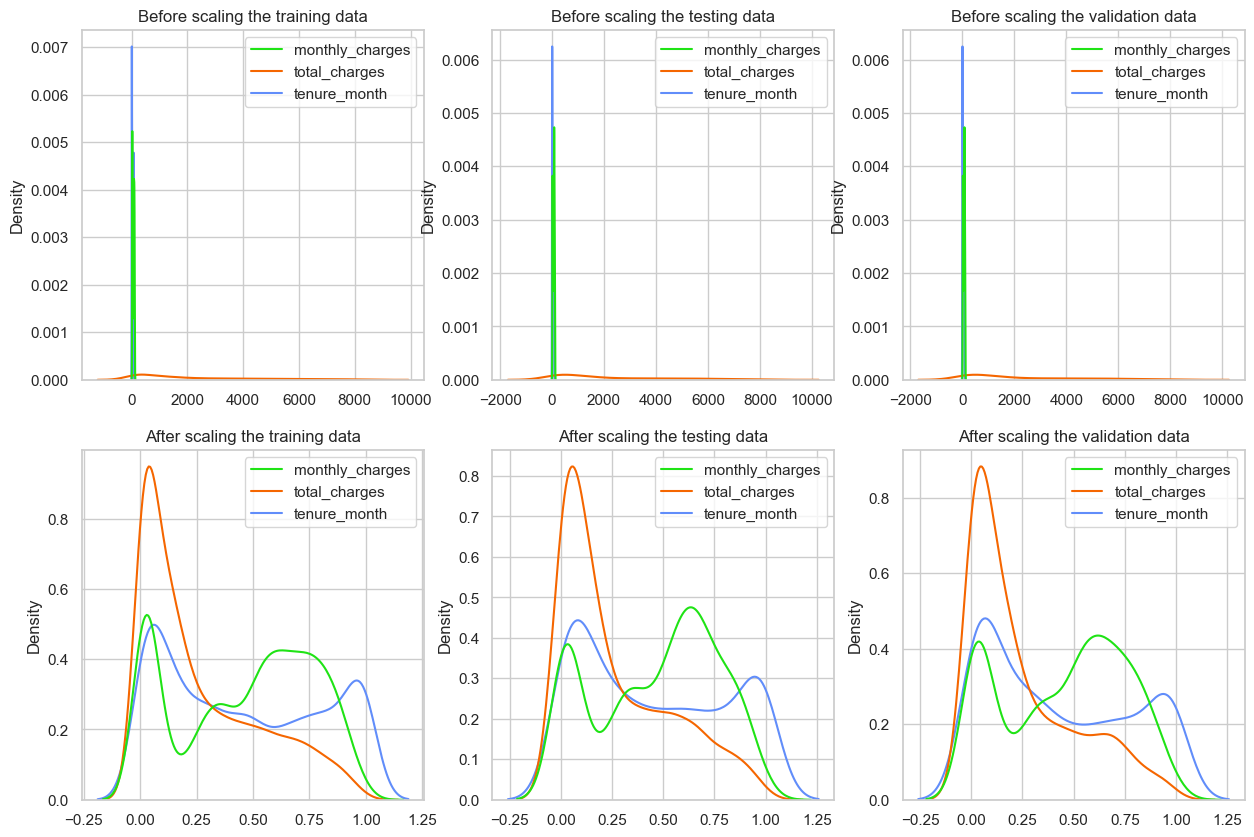

In [912]:
# Plots
fig, axs = plt.subplots(ncols = 3, nrows=2, figsize =(15, 10))
titles= ['training data','testing data', 'validation data']

for i, dataset in enumerate([X_train_unscaled[col_numeric], X_test_unscaled[col_numeric], X_valid_unscaled[col_numeric]]):
    sns.kdeplot(data=dataset, ax=axs[0][i], palette = palette[0:3])
    axs[0][i].set_title(f'Before scaling the {titles[i]}')  

for i, dataset in enumerate([X_train[col_numeric], X_test[col_numeric], X_valid[col_numeric]]):
    sns.kdeplot(data=dataset, ax=axs[1][i], palette = palette[0:3])
    axs[1][i].set_title(f'After scaling the {titles[i]}')

##  Equilibrar las clases

Anteriormente ya observamos las clases de la variable objetivo, las cuales están desequilibradas, el 73% de clientes que no se han ido y el 27% que se fueron, esto quiere decir que la clase mayoritaria es False y la clase minoritaria está representada por ceros y la minoritaria por unos.

Dicho esto, vamos ha equilibrar las clases haciendo una **combinación de submuestreos y sobremuestreos** con el fin de no tener que remover demaciadas observaciones de la clase mayoritaria que podrían ser importantes (entre más observaciones tengamos para entrenar nuestros modelos será mejor) o por otro lado tener que agregar demaciadas observaciones artificiales a nuestros datos.

La estrategia consistirá en 2 pasos: 
1) Aplicar submuestreo parcial con `RandomUnderSampler` equilibrando solo una proporción, la cual vamos a manipular con el parámetro `sampling_strategy=0.50`
2) Aplicar sobremuestreo total con `RandomOverSampler` la cual dejará equilibrada las clases 50-50.

Las clases `RandomUnderSampler` y `RandomOverSampler` son parte de la biblioteca imbalanced-learn. Una corta descripción a continuación:

- *RandomUnderSampler*: Esta clase reduce el número de muestras en la clase mayoritaria mediante la eliminación aleatoria de muestras hasta que se alcanza una relación de equilibrio con la clase minoritaria. El parámetro `sampling_strategy` se utiliza para especificar la relación de equilibrio deseada entre las clases.
- *RandomOverSampler*: Esta clase aumenta el número de muestras en la clase minoritaria mediante la replicación aleatoria de muestras hasta que se alcanza una relación de equilibrio con la clase mayoritaria.

In [913]:
# Backup training data before balance
X_train_unbalanced = X_train.copy()
y_train_unbalanced = y_train.copy()

print(f'Size X_train Before Balanced: {len(X_train_unbalanced)} samples.')

# Under-sampling
rus = RandomUnderSampler(random_state=12345, sampling_strategy=0.50)
X_train, y_train = rus.fit_resample(X_train, y_train)

print(f'- 1 Step Under-Sampler, {len(X_train_unbalanced) - len(X_train)} removed samples...')

# Over-sampling
ros = RandomOverSampler(random_state=12345)
X_train_len = len(X_train)
X_train, y_train = ros.fit_resample(X_train, y_train)

print(f'- 2 Step: Over-Sampler, {len(X_train) - X_train_len} added samples...')

print(f'Size X_train After Total Balanced: {len(X_train_unbalanced)} samples.')

Size X_train Before Balanced: 4930 samples.
- 1 Step Under-Sampler, 1045 removed samples...
- 2 Step: Over-Sampler, 1295 added samples...
Size X_train After Total Balanced: 4930 samples.


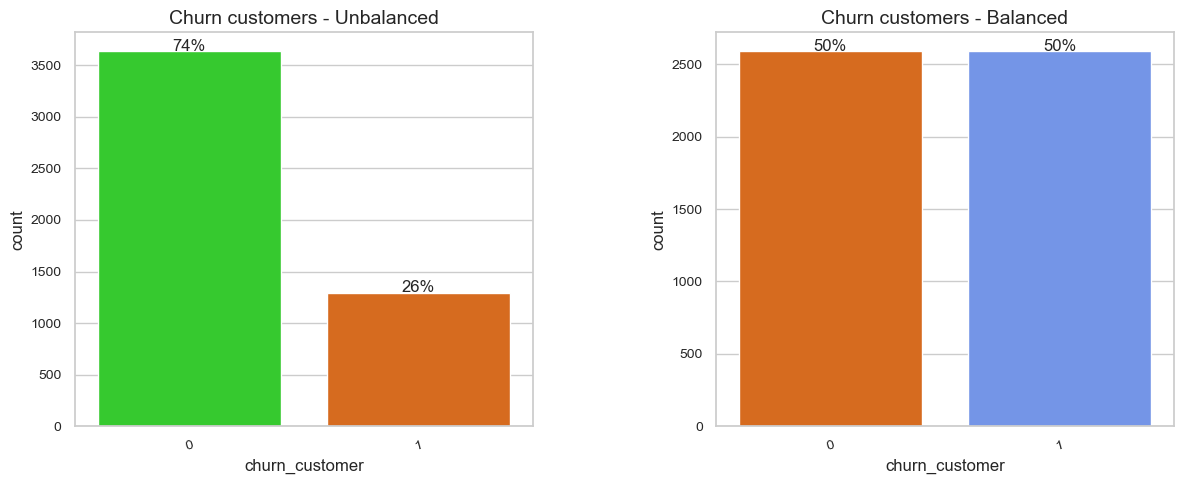

In [914]:
# Graph
columns = ['churn_customer', 'churn_customer']
titles  = ['Churn customers - Unbalanced', 'Churn customers - Balanced' ]
kind    = ['count', 'count']
data    = [y_train_unbalanced.to_frame(name=y.name), y_train.to_frame(name=y.name)]

plots(data=data, columns=columns, kind=kind, titles=titles)

Se realizó el balanceo de clases en el conjunto de datos de entrenamiento.

# Entrenar un modelo <a id='mod'></a>

Se aplicarán varios modelos de machine learning, se realizará ajuste de hiperparámetros y se eligirán los mejores.

Entre los algoritmos que usaremos estarán:

1. LogisticRegresion
2. DesicionTreeClassifier
3. RandomForestClassifier
4. XGBClassifier
5. LGBMClassifier
6. KNeighborsClassifier
7. Redes neuronales para clasificación (MLP de sklearn o Tensorflow)
  
El ajuste de hisperparámetros se realizará aplicando `GridSearchCV`

Crearemos un dataframe donde guardaremos los resultados de los modelos:

In [915]:
summary_models = pd.DataFrame(columns=['model', 'accuracy', 'f1', 'roc_auc' , 'estimator']).set_index(keys=['model'])
summary_models

Empty DataFrame
Columns: [accuracy, f1, roc_auc, estimator]
Index: []

Las métricas que usaremos para evaluar nuestro modelo es la precisión (`accuracy`), F1, y la curva ROC (`roc_auc`). 
- Accuracy es la proporción de predicciones correctas que el modelo ha hecho en comparación con el total de predicciones realizadas. 
- F1 es una medida de la precisión y el recall del modelo.
- El área bajo la curva ROC (roc_auc) es una medida de la capacidad del modelo para distinguir entre las clases positivas y negativas. Un valor de roc_auc cercano a 1 indica que el modelo tiene una buena capacidad para distinguir entre las clases, mientras que un valor cercano a 0.5 indica que el modelo no tiene capacidad para distinguir entre las clases.

### Funciones a usar

Se crean funciones y diccionarios a usar en esta sección, tales como:

- model_evaluator
- grid_search_cv
- diccionarios de hiperámetros para cada algoritmo


In [916]:
# Function grid_search for search best parameters

def grid_search_cv(estimator, params, X, y):
    '''
    parameters:
    "estimator": algorithm to train
    "params": hyperparameters
    "x": features train
    "y": target train
    return: the best parameters
    '''
  
    grid_search= GridSearchCV(estimator=estimator, param_grid=params, scoring='roc_auc', cv=5, error_score='raise')
    grid_search.fit(X, y)
    best_params  = grid_search.best_params_

    print(f'Best hiperparameters: {best_params}')
    return best_params

In [917]:
# Function model_evaluator for to evaluate each model and to Graph results

def model_evaluator(model, X_train, y_train, X_test, y_test):

    '''
    parameters:    
      model: model previously trained and with hyperparameter tuning
      X_train, y_train: features and target dataset train
      X_test, y_test: features and target dataset test
    calculate metrics accuracy and roc_auc
    show graphs
    return the values for accuracy and ROC-AUC
    '''
    
    results_metrics = pd.DataFrame(columns=['group', 'accuracy', 'f1', 'roc_auc']).set_index(keys=['group'])
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

    
    for group, X, y in (('train', X_train, y_train), ('test', X_test, y_test)):
        
        # Predictions
        y_prediction = model.predict(X)
        y_prediction_proba = model.predict_proba(X)[:, 1] # Probabilities of the positive class

        # METRICS Accuracy and ROC AUC
        accuracy = round(accuracy_score(y, y_prediction), 2)
        roc_auc = round(roc_auc_score(y, y_prediction_proba),2)  
        f1      = round(f1_score(y, y_prediction), 2)

        results_metrics.loc[group] = {'accuracy':accuracy, 'f1':f1, 'roc_auc':roc_auc}
        
        # ----------------------------------------------------------------------------------------------------------------------

        # PLOTS
        color = 'blue' if group == 'train' else 'orange'

        # axs[0] = Accuracy
        ax= axs[0]

        accuracy_thresholds = np.arange(0, 1.01, 0.05) # [0.0, 0.05, 0.10, 0.15, 0.20, ... , 1.0]
        accuracy_scores = [accuracy_score(y, y_prediction_proba>=threshold) for threshold in accuracy_thresholds]

        max_accuracy_score_idx = np.argmax(accuracy_scores)
        ax.plot(accuracy_thresholds, accuracy_scores, color=color, 
                label=f'{group}, max={accuracy_scores[max_accuracy_score_idx]:.2f} @ {accuracy_thresholds[max_accuracy_score_idx]:.2f}')
        
        # Defining crosses for some thresholds    
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(accuracy_thresholds-threshold))
            marker_color = 'green' if threshold != 0.5 else 'red'
            ax.plot(accuracy_thresholds[closest_value_idx], accuracy_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower center')
        ax.set_title(f'Accuracy') 

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(y, y_prediction_proba >= threshold) for threshold in f1_thresholds]

        # axs[1] = F1
        ax = axs[1]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{group}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Defining crosses for some thresholds         
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'green' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1') 



        # axs[2] = ROC-CURVE
        ax = axs[2]   
        fpr, tpr, roc_thresholds = roc_curve(y, y_prediction_proba)

        ax.plot(fpr, tpr, color=color, label=f'{group}, ROC AUC={roc_auc:.2f}')
        
        # Defining crosses for some thresholds  
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'green' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
        
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')

    display(results_metrics)
   
    return results_metrics

In [918]:
# Hyperparameter dictionaries

# LogisticRegression
# - `penalty`: La norma utilizada en la regularización. Las opciones son “l1” para la regularización L1 (valor absoluto) y 
#              “l2” para la regularización L2 (cuadrados).
# - `C`: La inversa de la fuerza de regularización. Valores más pequeños especifican una regularización más fuerte.
# - `solver`: Optimiza los parámetros. Las opciones son: “liblinear”, “saga”, “newton-cg”, “lbfgs” y “sag”. 
#             El solucionador “liblinear” es bueno para conjuntos de datos pequeños, mientras que los solucionadores “sag” y “saga” 
#             son más rápidos para conjuntos de datos grandes.
# - `max_iter`: El número máximo de iteraciones permitidas para la convergencia del solucionador.

params_lr = {'penalty': ['l1', 'l2'],
             'C': [0.01, 0.1, 1.0],
             'solver': ['liblinear', 'saga'],
             'max_iter': [500, 1000]}

# DecisionTreeClassifier
# - `criterion`: La función de medición de calidad utilizada para dividir los nodos. Las opciones son “gini” para la impureza de Gini, 
#                y "entropy" y "log_loss" ambos para la ganancia de información de Shannon.
# - `max_depth`: La profundidad máxima del árbol. Si se establece en “None”, los nodos se expandirán hasta que todas las hojas contengan menos de min_samples_split muestras.
# - `min_samples_split`: El número mínimo de muestras requeridas para dividir un nodo interno.
# - `min_samples_leaf`: El número mínimo de muestras requeridas para estar en una hoja.

params_dt = {'criterion': ['gini', 'entropy', 'log_loss'],
             'max_depth': [None, 5, 10],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}

# RandomForestClassifier
# - `n_estimators`: El número de árboles en el bosque.
# - `max_features`: El número máximo de características que se consideran para dividir un nodo.
# - `max_depth`: La profundidad máxima del árbol.
# - `min_samples_split`: El número mínimo de muestras requeridas para dividir un nodo interno.
# - `min_samples_leaf`: El número mínimo de muestras requeridas para estar en un nodo hoja.

params_rf = {'n_estimators': [100, 200, 500],
             'max_depth': [5, 10, 20],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
             'max_features': ['sqrt', 'log2']}

# XGBClassifier
# - `n_estimators`: El número de árboles en el bosque.
# - `max_depth`: La profundidad máxima del árbol.
# - `learning_rate`: Tasa de aprendizaje utilizada para actualizar los pesos con cada iteración.
# - `subsample`: La fracción de muestras utilizadas para entrenar cada árbol.
# - `colsample_bytree`: La fracción de características utilizadas para entrenar cada árbol.

params_xgb = {'n_estimators': [100, 200, 500],
              'max_depth': [5, 10, 20],
              'learning_rate': [0.01, 0.1, 1.0],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.5, 0.8, 1.0]}

# LGBMClassifier
# - `n_estimators`: El número de árboles en el bosque.
# - `max_depth`: La profundidad máxima del árbol.
# - `learning_rate`: Tasa de aprendizaje utilizada para actualizar los pesos con cada iteración.
# - `subsample`: La fracción de muestras utilizadas para entrenar cada árbol.
# - `colsample_bytree`: La fracción de características utilizadas para entrenar cada árbol.

params_lgbm = {'n_estimators': [100, 200, 500],
               'max_depth': [5, 10, 20],
               'learning_rate': [0.01, 0.1, 1.0],
               'subsample': [0.5, 0.8, 1.0],
               'colsample_bytree': [0.5, 0.8, 1.0]}


# CatBoostClassifier
# - `iterations`: El número máximo de iteraciones a realizar.
# - `depth`: La profundidad máxima del árbol.
# - `learning_rate`: Tasa de aprendizaje utilizada para actualizar los pesos con cada iteración.
# - `subsample`: La fracción de muestras utilizadas para entrenar cada árbol.
# - `colsample_bylevel`: La fracción de características utilizadas para entrenar cada árbol.

params_cb = {'iterations': [100, 200, 500],
             'depth': [5, 10, 16],
             'learning_rate': [0.01, 0.2],
             'subsample': [0.5, 0.8, 1.0],
             'colsample_bylevel': [0.5, 0.8]}


# KNeighborsClassifier
# - `n_neighbors`: El número de vecinos a considerar al clasificar una muestra.
# - `weights`: Función utilizada para ponderar los vecinos. Las opciones son ‘uniforme’ y ‘distancia’.
# - `algorithm`: Algoritmo utilizado para calcular los vecinos más cercanos. Las opciones son ‘auto’, ‘ball_tree’, ‘kd_tree’ y ‘brute’.

params_knb = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# MLPClassifier

# - `hidden_layer_sizes`: una tupla que representa el número de neuronas en cada capa oculta. 
#                         Por ejemplo, (50, 50) significa que hay dos capas ocultas con 50 neuronas cada una.
# - `activation`: la función de activación para la capa oculta. Las opciones son 'identity', 'logistic', 'tanh' y 'relu'.
# - `solver`: el algoritmo de optimización para actualizar los pesos. Las opciones son 'lbfgs', 'sgd' y 'adam'.
# - `alpha`: parámetro de regularización para controlar el sobreajuste. Los valores más altos significan una mayor regularización.
# - `learning_rate`: la tasa de aprendizaje para actualizar los pesos. Las opciones son 'constant', 'invscaling' y 'adaptive'.

params_mlp = {
    'hidden_layer_sizes': [(50,100,50),(100, 200, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.04],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [1000]
}


## Modelo 1: LogisticRegresion

In [919]:
# Tuning hyperparameters:
# params_lr = grid_search_cv(LogisticRegression(random_state=12345), params_lr, X_train, y_train)

accuracy    f1  roc_auc
group                         
train      0.77  0.78     0.86
test       0.75  0.63     0.84

CPU times: total: 688 ms
Wall time: 288 ms


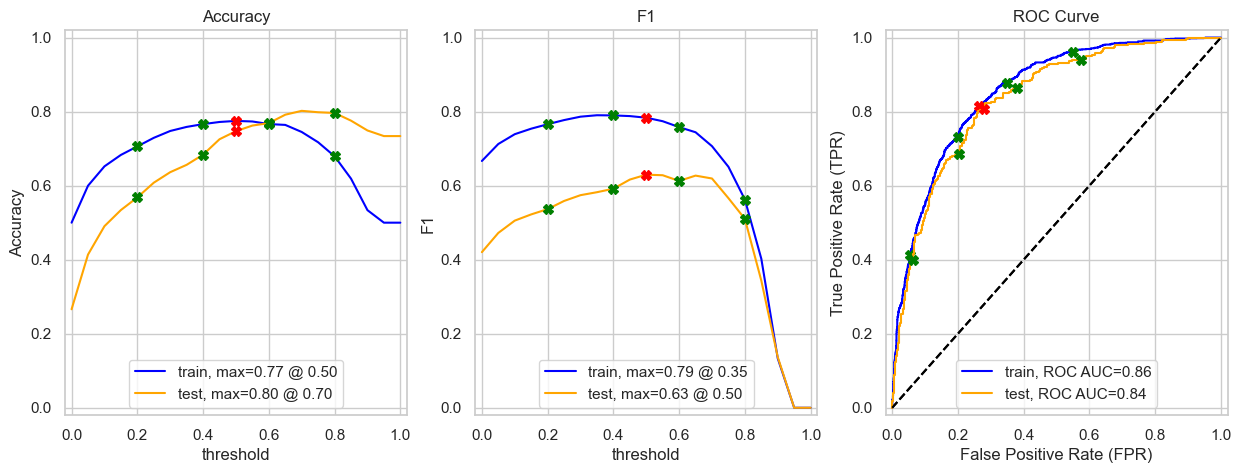

In [920]:
%%time
# Training LogisticRegression
params_lr = {'C': 1.0, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
model_lr = LogisticRegression(random_state= 12345, penalty=params_lr['penalty'], C=params_lr['C'], solver=params_lr['solver'])
model_lr.fit(X_train, y_train)
result_1 = model_evaluator(model_lr, X_train, y_train, X_test, y_test)

La precisión (accuracy) del modelo en los datos de entrenamiento es ligeramente mayor que en los datos de prueba, lo que sugiere que el modelo podría estar sobreajustando ligeramente. El valor de f1 también es mayor en los datos de entrenamiento que en los datos de prueba, lo que refuerza esta idea.

El valor de roc_auc es mayor en los datos de entrenamiento que en los datos de prueba, lo que también sugiere que el modelo podría estar sobreajustando ligeramente.

En general, parece que el modelo podría estar sobreajustando ligeramente a los datos de entrenamiento. Sería recomendable probar con otros modelos o ajustar los parámetros del modelo actual para mejorar su capacidad para generalizar a nuevos datos.

In [921]:
# Save Result
name = str(model_lr).split('(')[0] # model name
summary_models.loc[name] = {'accuracy': result_1.loc['test'].accuracy, 'f1': result_1.loc['test'].f1, 
                             'roc_auc': result_1.loc['test'].roc_auc, 'estimator': model_lr}

## Modelo 2: DesicionTreeClassifier

In [922]:
# Tuning hyperparameters:
# params_dt = grid_search_cv(DecisionTreeClassifier(random_state=12345), params_dt, X_train, y_train)

accuracy    f1  roc_auc
group                         
train      0.85  0.85     0.93
test       0.74  0.59     0.80

CPU times: total: 422 ms
Wall time: 497 ms


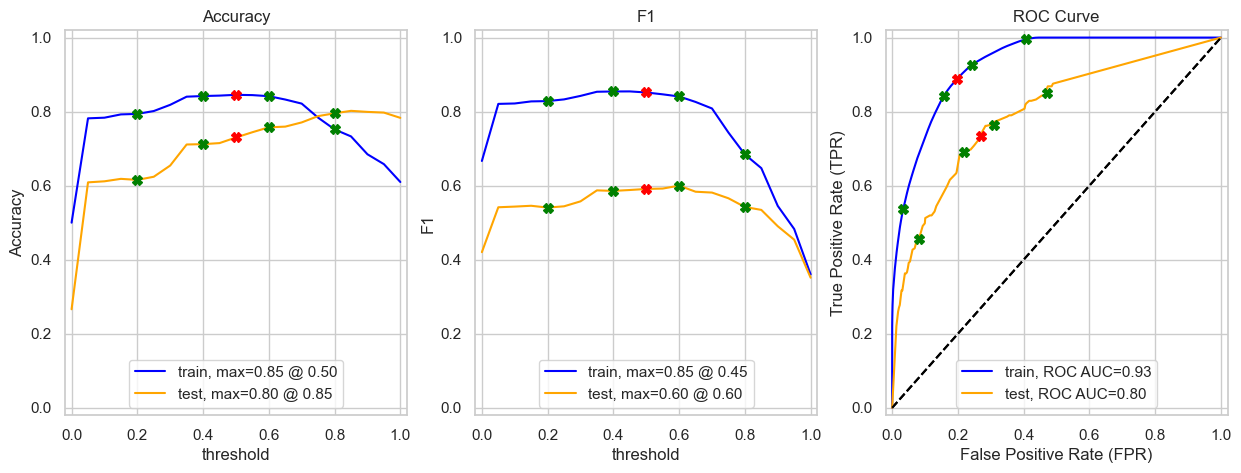

In [923]:
%%time
# Training DecisionTreeClassifier
params_dt = {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
model_dt = DecisionTreeClassifier(random_state=12345, criterion=params_dt['criterion'], max_depth=params_dt['max_depth'], 
                                    min_samples_leaf=params_dt['min_samples_leaf'], min_samples_split=params_dt['min_samples_split'])
model_dt.fit(X_train, y_train)

result_2 = model_evaluator(model_dt, X_train, y_train, X_test, y_test)

La precisión del modelo de árbol de decisión (DecisionTreeClassifier) en los datos de entrenamiento es mucho mayor que en los datos de prueba, lo que sugiere que el modelo podría estar sobreajustando a los datos de entrenamiento.

El valor de f1 es mayor en los datos de entrenamiento que en los datos de prueba, lo que refuerza la idea de que el modelo podría estar sobreajustando.
El valor de roc_auc es mayor en los datos de entrenamiento que en los datos de prueba, lo que también sugiere que el modelo podría estar sobreajustando.

En general, parece que el modelo está sobreajustando a los datos de entrenamiento y no generaliza bien a nuevos datos. Sería recomendable probar con otros modelos.

In [924]:
# Save Result
name = str(model_dt).split('(')[0] # model name
summary_models.loc[name] = {'accuracy': result_2.loc['test'].accuracy, 'f1': result_2.loc['test'].f1, 'roc_auc': result_2.loc['test'].roc_auc, 'estimator': model_dt}

## Modelo 3: RandomForestClassifier

In [925]:
# Tuning hyperparameters:
# params_rf = grid_search_cv(RandomForestClassifier(random_state=12345), params_rf, X_train, y_train)

accuracy    f1  roc_auc
group                         
train       1.0  1.00     1.00
test        0.8  0.65     0.84

CPU times: total: 3.42 s
Wall time: 3.68 s


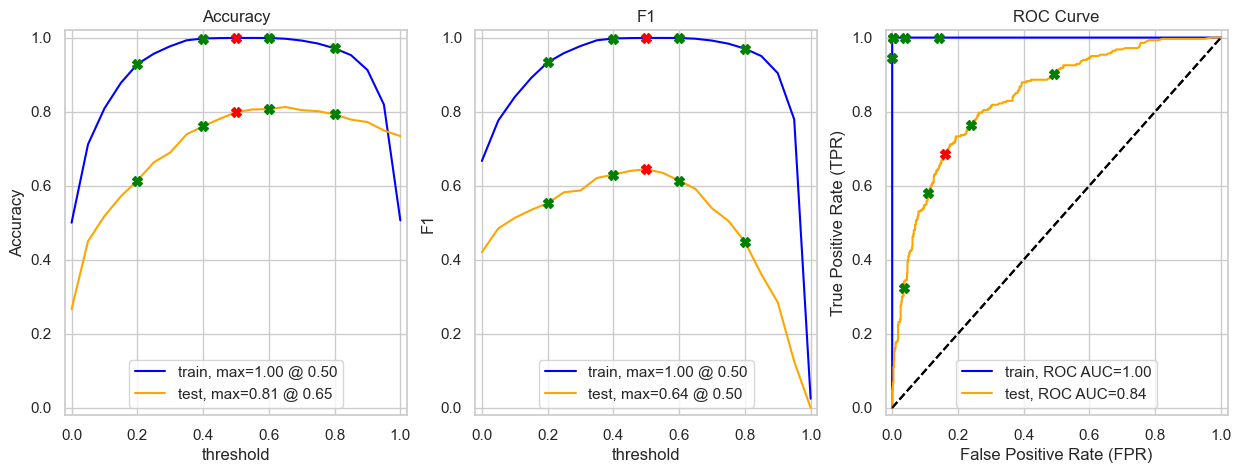

In [926]:
%%time
# Training RandomForestClassifier
params_rf = {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
model_rf = RandomForestClassifier(random_state=12345, max_depth=params_rf['max_depth'], max_features=params_rf['max_features'], 
                                  min_samples_leaf=params_rf['min_samples_leaf'], min_samples_split=params_rf['min_samples_split'],
                                  n_estimators=params_rf['n_estimators'])
model_rf.fit(X_train, y_train)
result_3 = model_evaluator(model_rf, X_train, y_train, X_test, y_test )

En este caso, el modelo RandomForestClassifier obtuvo una precisión en los datos de entrenamiento es perfecta (1.0), lo que sugiere que el modelo podría estar sobreajustando a los datos de entrenamiento. 

El valor de f1 es mayor en los datos de entrenamiento que en los datos de prueba, lo que refuerza la idea de que el modelo podría estar sobreajustando. 

El valor de roc_auc es mayor en los datos de entrenamiento que en los datos de prueba, lo que también sugiere que el modelo podría estar sobreajustando.

En general, el modelo está sobreajustando a los datos de entrenamiento y no generaliza bien a nuevos datos. Sería recomendable probar con otros modelos.

In [927]:
# Save Result
name = str(model_rf).split('(')[0] # model name
summary_models.loc[name] = {'accuracy': result_3.loc['test'].accuracy, 'f1': result_3.loc['test'].f1, 'roc_auc': result_3.loc['test'].roc_auc, 'estimator': model_rf}

## Modelo 4: XGBClassifier



In [928]:
# Tuning hyperparameters:
# params_xgb = grid_search_cv(XGBClassifier(random_state=12345), params_xgb, X_train, y_train)

accuracy    f1  roc_auc
group                         
train      1.00  1.00     1.00
test       0.79  0.62     0.83

CPU times: total: 11.8 s
Wall time: 1.23 s


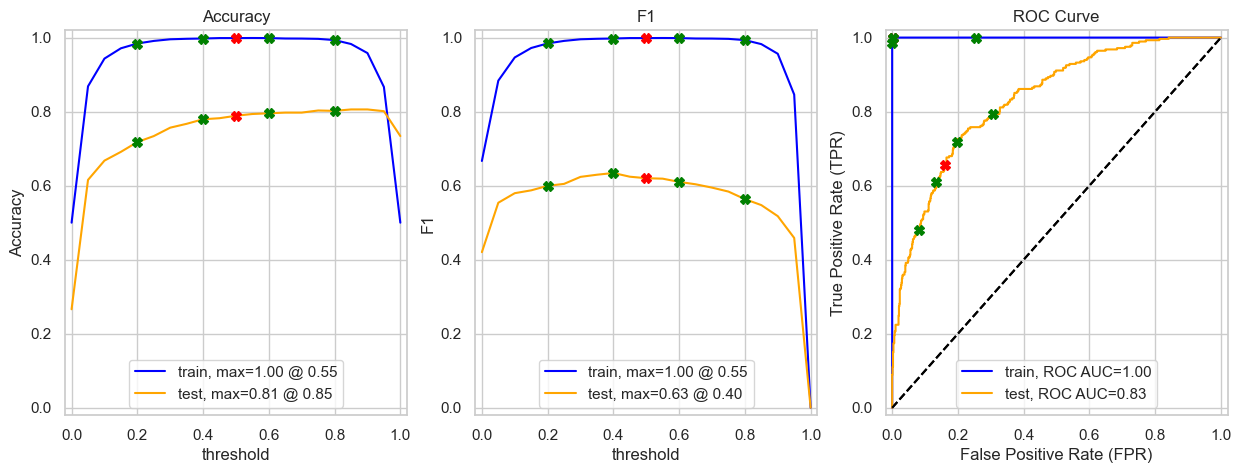

In [929]:
%%time
# Training XGBClassifier
params_xgb = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200, 'subsample': 1.0}
model_xgb = XGBClassifier(random_state=12345, colsample_bytree= params_xgb['colsample_bytree'], 
                          learning_rate=params_xgb['learning_rate'], max_depth=params_xgb['max_depth'], 
                          n_estimators=params_xgb['n_estimators'], subsample=params_xgb['subsample'])

model_xgb.fit(X_train, y_train)
result_4 = model_evaluator(model_xgb, X_train, y_train, X_test, y_test)

Parecido al modelo anterior, el modelo con XGBClassifier obtuvo un sobreajuste con los datos de entrenamiento, respecto a las métricas obtenidas en los datos de prueba. Las métricas en nuestras pruebas podrían mejorar.

In [930]:
# Save Result
name = str(model_xgb).split('(')[0] # model name
summary_models.loc[name] = {'accuracy': result_4.loc['test'].accuracy, 'f1':result_4.loc['test'].f1, 'roc_auc': result_4.loc['test'].roc_auc, 'estimator': model_xgb}

## Modelo 5: LGBMClassifier

In [931]:
# Tuning hyperparameters:
# params_lgbm = grid_search_cv(LGBMClassifier(random_state=12345), params_lgbm, X_train, y_train)

accuracy    f1  roc_auc
group                         
train      0.99  0.99     1.00
test       0.79  0.64     0.83

CPU times: total: 7.67 s
Wall time: 816 ms


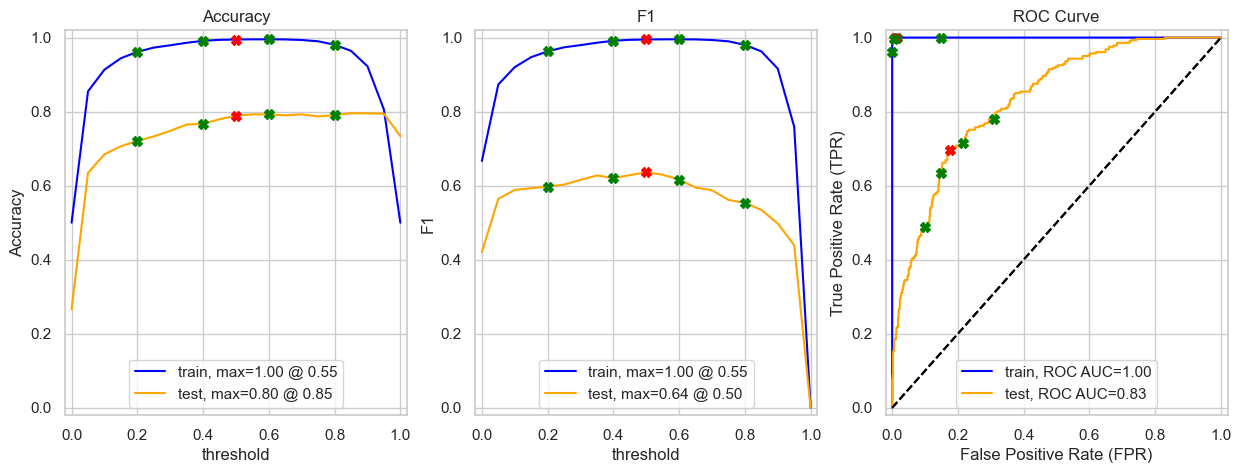

In [932]:
%%time
# Training LGBMClassifier
params_lgbm = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500, 'subsample': 0.5}
model_lgbm = LGBMClassifier(random_state=12345, colsample_bytree=params_lgbm['colsample_bytree'], learning_rate=params_lgbm['learning_rate'],
                            max_depth=params_lgbm['max_depth'], n_estimators=params_lgbm['n_estimators'], subsample=params_lgbm['subsample'])
                            
model_lgbm.fit(X_train, y_train)
result_5 = model_evaluator(model_lgbm, X_train, y_train, X_test, y_test)

In [933]:
# Save Result
name = str(model_lgbm).split('(')[0] # model name
summary_models.loc[name] = {'accuracy': result_5.loc['test'].accuracy, 'f1':result_5.loc['test'].f1, 'roc_auc': result_5.loc['test'].roc_auc, 'estimator': model_lgbm}

## Modelo 6: KNeighborsClassifier

In [934]:
# Tuning hyperparameters:
# params_knb = grid_search_cv(KNeighborsClassifier(), params_knb, X_train, y_train)

accuracy    f1  roc_auc
group                         
train      1.00  1.00     1.00
test       0.69  0.57     0.78

CPU times: total: 1.62 s
Wall time: 1.8 s


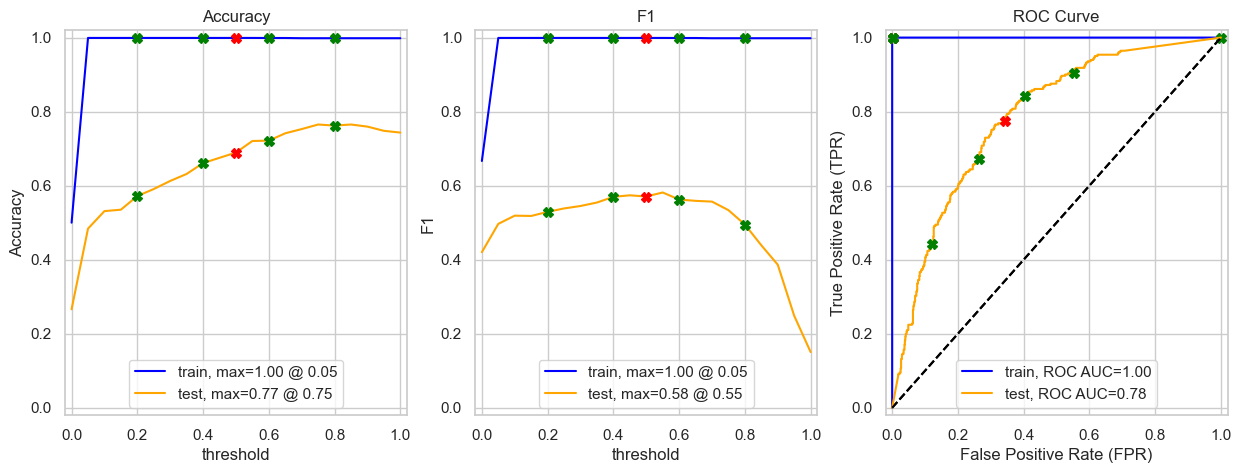

In [935]:
%%time
# Training KNeighborsClassifier
params_knb = {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'distance'}
model_knb = KNeighborsClassifier(algorithm=params_knb['algorithm'], n_neighbors=params_knb['n_neighbors'], weights=params_knb['weights'])
model_knb.fit(X_train, y_train)

result_6 = model_evaluator(model_knb, X_train, y_train, X_test, y_test)

En este modelo con KNeighborsClassifier, la precisión en los datos de entrenamiento es perfecta (1.0).

El valor de f1 es mayor en los datos de entrenamiento que en los datos de prueba. 

El valor de roc_auc es mayor en los datos de entrenamiento que en los datos de prueba. 

En general, parece que el modelo está sobreajustando a los datos de entrenamiento y no generaliza bien a nuevos datos.

In [936]:
# Save Result
name = str(model_knb).split('(')[0] # model name
summary_models.loc[name] = {'accuracy': result_6.loc['test'].accuracy, 'f1':result_6.loc['test'].f1, 'roc_auc': result_6.loc['test'].roc_auc, 'estimator': model_knb}

## Modelo 7: MLPClassifier (ANN)

In [937]:
# Tuning hyperparameters:
# params_mlp = grid_search_cv(MLPClassifier(random_state=12345), params_mlp, X_train, y_train)

accuracy    f1  roc_auc
group                         
train      0.98  0.98     1.00
test       0.72  0.54     0.77

CPU times: total: 1min
Wall time: 17.9 s


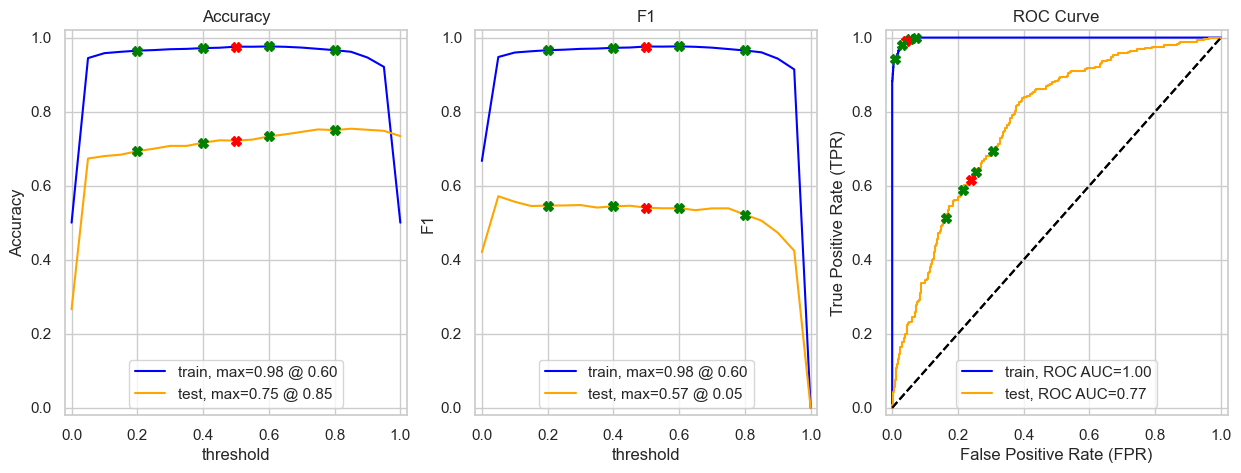

In [938]:
%%time
# Training MLPClassifier
params_mlp = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 200, 100), 'learning_rate': 'constant', 'max_iter': 1500, 'solver': 'adam'}

model_mlp = MLPClassifier(random_state=12345, activation=params_mlp['activation'], alpha=params_mlp['alpha'], 
                          hidden_layer_sizes=params_mlp['hidden_layer_sizes'], learning_rate=params_mlp['learning_rate'],
                          max_iter=params_mlp['max_iter'], solver=params_mlp['solver'], warm_start=True)

model_mlp.fit(X_train, y_train)
result_7 = model_evaluator(model_mlp, X_train, y_train, X_test, y_test)

Este modelo al igual que los anteriores, tiene sobreajuste en los resultados de entrenamiento frente a los de prueba.

In [939]:
# Save Result

name = str(model_mlp).split('(')[0] # model name
summary_models.loc[name] = {'accuracy': result_7.loc['test'].accuracy, 'f1':result_7.loc['test'].f1, 'roc_auc': result_7.loc['test'].roc_auc, 'estimator': model_mlp}

# Análisis de resultados <a id='ana'></a>

Hemos entrenado 7 modelos diferentes los cuales hemos realizado ajustes de hiperparámetros para obtener mejores resultados. La evaluación mediante las métricas roc?auc y accuracy, presentamos a continuación:

In [940]:
summary_models

accuracy    f1  roc_auc  \
model                                             
LogisticRegression          0.75  0.63     0.84   
DecisionTreeClassifier      0.74  0.59     0.80   
RandomForestClassifier      0.80  0.65     0.84   
XGBClassifier               0.79  0.62     0.83   
LGBMClassifier              0.79  0.64     0.83   
KNeighborsClassifier        0.69  0.57     0.78   
MLPClassifier               0.72  0.54     0.77   

                                                                estimator  
model                                                                      
LogisticRegression      LogisticRegression(penalty='l1', random_state=...  
DecisionTreeClassifier  DecisionTreeClassifier(max_depth=10, min_sampl...  
RandomForestClassifier  (DecisionTreeClassifier(max_depth=20, max_feat...  
XGBClassifier           XGBClassifier(base_score=None, booster=None, c...  
LGBMClassifier          LGBMClassifier(max_depth=20, n_estimators=500,...  
KNeighborsClassifier    KNeighborsClassifier(algorithm='ball_tree', n_...  
MLPClassifier           MLPClassifier(activation='tanh', hidden_layer_...

En general, parece que el modelo de Random Forest es el mejor modelo en términos de precisión (accuracy), f1 y roc_auc en los datos de prueba.

Revisemos las variables más importantes en este modelo:

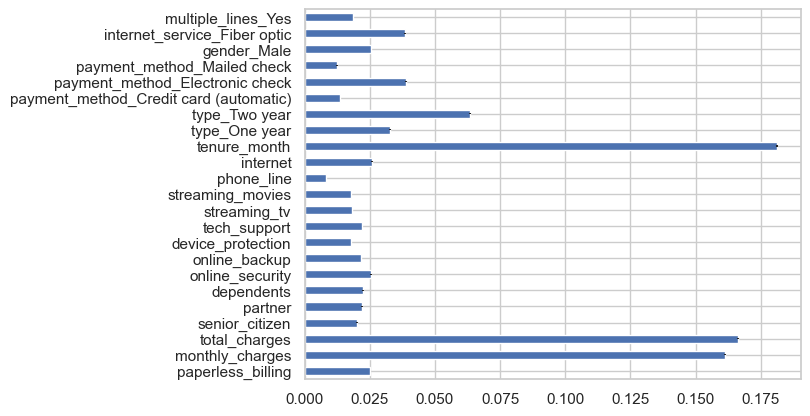

In [941]:
feature_names = [f"{i}" for i in X.columns]
importances = best_model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

forest_importances.plot.barh(yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()    

El tiempo de permanencia en meses los cargos mensuales y totales del cliente al parecer resaltan como las características más importantes de nuestro modelo.

Vamos a realizar la validación de nuestro modelo ganador con nuestros datos de validación X_valid, y_valid.

accuracy    f1  roc_auc
group                         
train      0.98  0.98     1.00
test       0.73  0.55     0.78

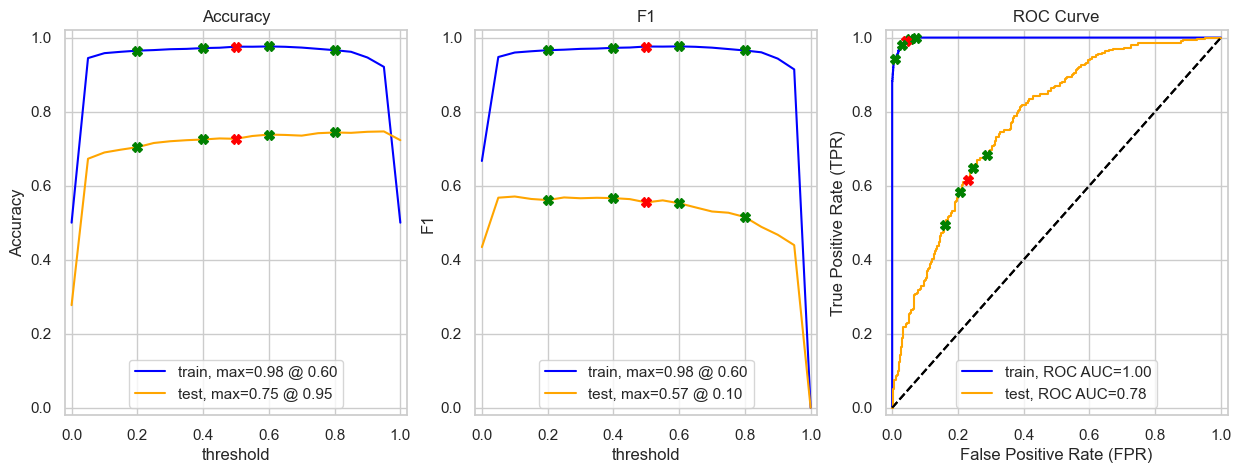

In [942]:
best_model = summary_models.loc['RandomForestClassifier'].estimator
valid_result = model_evaluator(model_mlp, X_train, y_train, X_valid, y_valid)

# Conclusiones y recomendaciones <a id='con'></a>

En base a los resultados obtenidos, se sugeriere que la empresa Interconnect utilice el modelo `RandomForestClassifier` para predecir si un cliente abandonará o no la empresa.

Además, se puede recomendar que la empresa realice un seguimiento de los clientes que tienen una alta probabilidad de abandonar la empresa y les ofrezca incentivos para que permanezcan en la empresa. Por ejemplo, se pueden ofrecer descuentos en productos o servicios, o se pueden ofrecer programas de fidelización para los clientes leales.

*Patrones encontrados en los clientes que abandonaron la empresa:*
- No hay diferencias en hombres y mujeres.
- La mayoría NO eran adultos mayores y NO tenían cargas familiares.
- La mayoría tenían entre 0 a 10 meses de permanencia en el contrato.
- La mayoría contaba con facturación electrónica.
- La mayoría pagaba mediante cheque electróncio.
- La mayoría tenía contratada una o más líneas telefónicas.
- La mayoría pagaba mes a mes la factura.
- La mayoría usaba fibra óptica.